# OVERVIEW AND METHODOLOGY

Welcome to Rob Guzman's case study! In this case study, we begin with data from a CSV file containing Uber and Lyft data. At base, there are two primary goals:

1. Understand the data and clean it as best as we can.
2. Perform some basic analysis and provide leads to future steps.

A few additional points:

- Part of understanding the data is determining which columns are useful, which ones are largely useless, and which ones can be transformed into new columns. We will do all of this. At the end of the process, I will also say a few things about loading and storing this dataset in a relational database (if a file like this were loaded on a routine basis).
- When we perform our cleaning of the data, not everything will likely be entirely pristine. Capturing every detail would take time and much testing, and future files might contain anomalies that we do not see here. For the sake of this case study, we will pursue the "80-20 rule" and try to get the biggest bang for our buck.
- This notebook is written in "real-time." What this means is that as you venture down you will see my progression through the data as I did originally. Thus, many statements are run to see results and explore the data. Data cleanining and analysis is an _inductive_ process, so we must look at the way the data actually are in order to gain an idea as to what we should do with it (or to it).
- Finally, when we get to the end part of the notebook and discuss data anlysis, I will provide several leads to possible future projects that one could pursue with this data. This is also not complete, but is meant to stimulate discussion.

With that, imagine yourself in the same position that a customer in one of these records: sit back, and enjoy the ride!

# PART 1: EXPLORATORY ANALYSIS AND DATA CLEANING

We begin with imports and load the raw data into a Pandas dataframe. We will make extensive use of the Pandas library. We also run the info() function to get an idea as to what the data look like. Note that we receive a warning about mixed types: this is to be expected, since the data are likely filthy.

In [1]:
import pandas as pd
import csv
import datetime
import numpy as np
import re

fileName = "C:/Users/rg255/Downloads/Data_Rideshare/Data_RideShare.csv"
rawData = pd.read_csv(fileName)

rawData.info()

C:\Users\rg255\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\IPython\core\interactiveshell.py:3062: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1877060 entries, 0 to 1877059
Data columns (total 33 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   merchant_name             object 
 1   user_id                   object 
 2   order_number              object 
 3   order_time                object 
 4   email_time                object 
 5   insert_time               object 
 6   update_time               object 
 7   order_total_amount        float64
 8   order_points              float64
 9   order_shipping            float64
 10  order_tax                 float64
 11  order_subtotal            float64
 12  order_total_qty           float64
 13  product_description       object 
 14  product_subtitle          object 
 15  item_quantity             float64
 16  item_price                float64
 17  digital_transaction       int64  
 18  checksum                  object 
 19  product_reseller          object 
 20  product_category        

One thing to check immediately is whether or not there are any exact duplicates in the data. In rare cases, one might expect such duplicates, but it is generally a bada practice.

In [2]:
rawData.duplicated().value_counts()

False    1877060
dtype: int64

We are fortunate that there are no exact duplicates. I am sure we will find other reasons to remove rows, though.

Now that we have loaded the data in its raw form, we want to do some exploratory data analysis on the various columns to ensure that we do not have any bad data. As part of our larger goal of understanding the data, we will need to attach significance and an interpretation to each column in this dataset. At the end, I will summarize our findings here. If you are interested in the progression, read on.

## MERCHANT NAME

We begin with the merchant name, which we expect to have two values: Uber and Lyft. Let's verify this with the value_counts() function.

In [3]:
rawData["merchant_name"].value_counts()

Uber    1292235
Lyft     584825
Name: merchant_name, dtype: int64

As expected, everything is tagged as either Uber or Lyft. Since merchant_name is a string, we would likely want to create our own table for merchants in our relational implementation of this data. That way, we can save space by storing an integer id instead of the full name. Not to mention,  we can catch errors in spelling and new vendors with this approach that might come about in the future.

## USER_ID

The next field to look at is user_id. For this value, we are interested in a few questions, such as:

1) what is the intended type?
2) what is the cardinality?
3) are there any that are missing?

We can proceed to answer these questions with the following commands. The first command will check the size of the row's contents (which I suspect we will see regularity in, since the field appears to be a GUID of some variety). The second will look for uniqueness across the rows (I do not expect this to hold, since one customer should be able to have multiple orders in the dataset). The third will look for particular values that have a high cardinality, which might indicate some problem. The fourth will look for missing data.

In [4]:
rawData["user_id"].apply(len).value_counts()

64    1877060
Name: user_id, dtype: int64

In [5]:
rawData.groupby("user_id")["merchant_name"].nunique()

user_id
00014dfd77b41f5fa092a161f01ac5e63db0cbdc7bf3db9457b4748755003f03    2
000226075b0be56c5a97290d4fbb03726e05b60d6c291cbc35a54edd9776013a    1
000389577a74818063cf0cd729df90cdd29b7aec12870ee9d03ad3ae6d9600b7    2
00079f4d49e4a26390863a9f7095a33c65d1ae056ba7f04fc49e62cf7454dba4    1
000a460deaef4601c9c628fdb672bf9dd370a24fe4381b295cd5577a073c61dd    1
                                                                   ..
fff90c2e3e918635517c38edfd6fcb7ea31f79a55a31908d2238795f6451538d    1
fff91ead0bcdd9e9a92226e8c8f0c0ebf829ddc72559ac01583432f04a81de86    2
fff952d9b26c067b5f7d3b072fed02c1769c80fe3c6db5223131bc3c61804ff9    1
fffa8b12ea52b9e228c1ba4bd6b3ff2f0780a6cb6388b49f6a075c55575eed9e    1
fffcfd1f4826db24e7f72bcd40f387dc3257d89ccd99e3ca52ecaa752784fb21    1
Name: merchant_name, Length: 29291, dtype: int64

In [6]:
rawData["user_id"].value_counts()

5a2ddafb9b4bc4dc0e506e0cc74ba53469295908e586a8e63bf3930a7b77ff9f    3137
bcf5acdc42396cd2c5e86689627f42f096e101dd56afb74f54baae39c2d4f74d    2463
1de4cda1ee476a68486e3f5755099343e971523826ed258e9b76dce8193b9435    2341
bfe91c67be3a0b2bf89b2a124f640f85e96253b0242d62788a16f7aac1660598    2332
057c3839aede4b0b466b9b0203cfc82824d4c5e3d9c7b41e763b9b550f2a1f84    2285
                                                                    ... 
30689ff7867a81b62bad7294689602634d659be6efc906c5ab3794b0e0c2eb9c       1
d4787b589c40f1629e073f3254071ddfcb9d78f1cc2357fafc3e97e9a19b8209       1
479d24a7379caf0e3257cf0f3fe9b77e677c7a2722f830a0577d03828990b006       1
ce0386c2c21dd8365936a50f02ff1fb985ba251735898f5f32787a5ab249df59       1
c6ec6e7f6d1abd0a4b785631d0f1944abd8f22d96bd9ab388e8e6fa0eae0c5ae       1
Name: user_id, Length: 29291, dtype: int64

In [7]:
rawData["user_id"].isnull().value_counts()

False    1877060
Name: user_id, dtype: int64

As we can see from the results above:

1) There no missing values in the data.
2) Everything is a 64 character long string.
3) That there are cases where a single user_id has many orders.
4) Some user_ids are used by both Lyft and Uber data.

These findings raise some interesting questions.

First, what is going on with those customers that have hundreds or thousands of orders? Are these really individuals making thousands of trips? This seems to me to be unlikely; I think it is more likely that this is a shared account, perhaps corporate, that allows for many individuals to take trips, perhaps simultaneously. One way to validate this would be to look for instances where a single user_id has more than one simultaneous trip. This is something we should check later after we have cleaned the date and time data. So let's put a pin in that one (we will revisit it).

Another question is: is the user_id field universal for this file? Did our vendor consolidate all of their user data into a single table and then assign unique Ids to each of them, so that a user_id that is shared by both Uber and Lyft are really the same person? If so, it means that we could potentially be able to see whether individuals _switch vendors_. That would be something!

I think it is likely true, given the nature of the field. Assume for the moment that these user_ids were assigned by the vendors themselves. What are the odds that both Uber and Lyft would choose to use the same mechanism for tracking customers (64 character long strings) **and** that they would have a collision with such a gargantuan number of possibilities for assignment of these ids. The number of possible ids is approximately 36^64 = 4.01 x 10^99 give or take a few, since I am sure there are  pathological cases (all 1's or all 0's) removed.

We can do some basic analysis assuming it is correct and abandon those results if it turns out to be false. This would be something that we would ask the vendor before we went to the bank with it.

## ORDER_NUMBER

Anyways, on to the order_number field. We can ask the same questions as we did for user_id and note that in theory, this field should be particularly cleaned. The reason is that I would expect that **order_number makes sense as a primary key** for this dataset. If there is more than one row for each order_number, that would raise some serious questions about duplication.

Below, we run a few commands to check for missing values, whether or not the same order_number is used by different merchants, and then, if we find misssing values or dupes, we will try to gain some basic information about some of those rows. 

In [8]:
rawData["order_number"].isnull().value_counts()

False    1837187
True       39873
Name: order_number, dtype: int64

In [9]:
rawData[rawData["order_number"].isnull() == True]["email_subject"].value_counts()

Confirmation: You just got paid                     14841
****** getting paid                                 11811
Lyft Tip Increase Receipt                            4248
Your Ride Pass is ready to roll                      2536
You're getting paid                                   481
                                                    ...  
*****'s last 44 minutes riding with Uber **             1
********* last 4**** minutes riding with Uber **        1
*******'s last 169 minutes riding with Uber **          1
*******'s last 285 minutes riding with Uber **          1
******'s last 64 minutes riding with Uber **            1
Name: email_subject, Length: 537, dtype: int64

There are missing values (that is, null order_numbers) in this dataset. If we are interested in quality data, a record with no order_number is probably not good data. In this case, it is a relatively small amount of data (roughly 2% of the data). If we take a cursory look at the the emails associated with the data that are missing order_numbers, we can see that they do not appear to be passenger pickups. Rather, they refer to getting paid, or buying a ride pass, or getting a tip increase.

To simplify the analysis, we can remove these rows from the data set and continue with only those rows that have an order_number. We can always do a separate analysis in the future for the data that do not have an order_number. So let's remove those cases. Let's move on to cardinality.

In [10]:
#Fix for missing order_number
rawData = rawData[rawData['order_number'].notna()]

In [11]:
multipleOrders = rawData[rawData.groupby('order_number')['merchant_name'].transform('nunique') > 1]
multipleOrders

,merchant_name,user_id,order_number,order_time,email_time,insert_time,update_time,order_total_amount,order_points,order_shipping,...,item_id,order_pickup,from_domain,email_subject,delivery_date,start_source_folder_date,end_source_folder_date,file_id,source_dttimestamp,dttimestamp


In [12]:
rawData[rawData["order_number"] == 'f53f4d13-e355-442a-af0e-385bbab1e20d']

,merchant_name,user_id,order_number,order_time,email_time,insert_time,update_time,order_total_amount,order_points,order_shipping,...,item_id,order_pickup,from_domain,email_subject,delivery_date,start_source_folder_date,end_source_folder_date,file_id,source_dttimestamp,dttimestamp
642787,Uber,0a476432e254265e760aaef7a7ad76c76cd456b8ae4ef4...,f53f4d13-e355-442a-af0e-385bbab1e20d,2017-08-11 00:00:00.000,2017-08-11 09:19:17.000,2017-08-11 09:21:39.000,2019-02-03 09:29:29.000,8.21,NaN,NaN,...,NaN,1,uber.us@uber.com,Your Thursday evening trip with Uber,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453
1635799,Uber,0a476432e254265e760aaef7a7ad76c76cd456b8ae4ef4...,f53f4d13-e355-442a-af0e-385bbab1e20d,2017-08-11 00:00:00.000,2017-08-11 09:19:17.000,2017-08-11 09:20:52.000,2019-02-03 10:05:16.000,8.21,NaN,NaN,...,NaN,1,uber.us@uber.com,****** took an Uber trip on Aug 11,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453


In [13]:
rawData[rawData["order_number"] == 'eba603be-154a-41fa-9108-3d79437dda0a']

,merchant_name,user_id,order_number,order_time,email_time,insert_time,update_time,order_total_amount,order_points,order_shipping,...,item_id,order_pickup,from_domain,email_subject,delivery_date,start_source_folder_date,end_source_folder_date,file_id,source_dttimestamp,dttimestamp
685409,Uber,0a476432e254265e760aaef7a7ad76c76cd456b8ae4ef4...,eba603be-154a-41fa-9108-3d79437dda0a,2019-05-09 00:00:00.000,2019-05-10 01:53:52.000,2019-05-10 01:54:14.000,2019-05-10 01:54:14.000,10.33,NaN,NaN,...,NaN,1,uber.us@uber.com,Your Thursday evening trip with Uber,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453
1637444,Uber,0a476432e254265e760aaef7a7ad76c76cd456b8ae4ef4...,eba603be-154a-41fa-9108-3d79437dda0a,2019-05-09 00:00:00.000,2019-05-10 01:53:55.000,2019-05-10 01:54:13.000,2019-05-10 01:54:13.000,10.33,NaN,NaN,...,NaN,1,uber.us@uber.com,Your Thursday evening trip with Uber,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453


In [14]:
rawData[rawData["order_number"] == 'c5e4242c-fd0f-40fb-83b3-b7c6da3d5aaa']

,merchant_name,user_id,order_number,order_time,email_time,insert_time,update_time,order_total_amount,order_points,order_shipping,...,item_id,order_pickup,from_domain,email_subject,delivery_date,start_source_folder_date,end_source_folder_date,file_id,source_dttimestamp,dttimestamp
1826464,Uber,49db41a62acde6bf83031945f020d4fcc62fb31d4b4bd3...,c5e4242c-fd0f-40fb-83b3-b7c6da3d5aaa,2018-10-04 00:00:00.000,2018-10-04 20:37:36.000,2019-09-13 06:29:09.000,2019-09-13 06:29:09.000,5.0,NaN,NaN,...,NaN,1,uber.us@uber.com,Receipt for canceled trip on Thursday afternoon,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453
1827339,Uber,f1a1a64fa4a03a39c0388410c28418010c09d5eca78fff...,c5e4242c-fd0f-40fb-83b3-b7c6da3d5aaa,2018-10-04 00:00:00.000,2018-10-04 20:37:39.000,2019-09-19 01:35:28.000,2019-09-19 01:35:28.000,5.0,NaN,NaN,...,NaN,1,uber.us@uber.com,Receipt for canceled trip on Thursday afternoon,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453


In [15]:
rawData[rawData["order_number"] == '54f01ff4-47f2-4b90-b156-4ad5f6fa3466']

,merchant_name,user_id,order_number,order_time,email_time,insert_time,update_time,order_total_amount,order_points,order_shipping,...,item_id,order_pickup,from_domain,email_subject,delivery_date,start_source_folder_date,end_source_folder_date,file_id,source_dttimestamp,dttimestamp
989232,Uber,49db41a62acde6bf83031945f020d4fcc62fb31d4b4bd3...,54f01ff4-47f2-4b90-b156-4ad5f6fa3466,2017-10-02 00:00:00.000,2017-10-03 02:33:20.000,2019-09-13 05:02:02.000,2019-09-13 05:02:02.000,27.85,NaN,NaN,...,NaN,1,receipts.nyc.suburbs@uber.com,Your Monday evening trip with Uber,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453
1323144,Uber,f1a1a64fa4a03a39c0388410c28418010c09d5eca78fff...,54f01ff4-47f2-4b90-b156-4ad5f6fa3466,2017-10-02 00:00:00.000,2017-10-03 02:33:21.000,2019-09-18 23:33:30.000,2019-09-18 23:33:30.000,27.85,NaN,NaN,...,NaN,1,receipts.nyc.suburbs@uber.com,Your Monday evening trip with Uber,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453


Another thing that we notice is that there are also cases where the order_number is shared by multiple rows, and they do seem to be the same transaction. We can tell by observing a few examples that nearly everything is the same for these rows, with minor differences. Sometimes, the user_id is different. Sometimes, the user_id is the same and there is a small difference in the insert and update times (which also seem to always be the same, making the columns redundant). We can kill several birds with one stone and look into those cases where there is more than one row for the same order_number and determine how many occur that are of this latter sort (i.e. they have the same data, in essence, but with a minor difference in their datetime of insertion / update). In that case, we can select one of the two and remove the other. But for the first case (i.e. they have different user_ids), this might indicate a potentially duplicate user_id.

In either case, let's start by checking the assumption that insert_time and update_time are the same.

In [16]:
rawData[rawData.insert_time != rawData.update_time]

,merchant_name,user_id,order_number,order_time,email_time,insert_time,update_time,order_total_amount,order_points,order_shipping,...,item_id,order_pickup,from_domain,email_subject,delivery_date,start_source_folder_date,end_source_folder_date,file_id,source_dttimestamp,dttimestamp
15,Lyft,2b1abda962224acdfacdb7d774cfd444463f4a4cd4438a...,1102508880002627982,2018-02-18 17:00:00.000,2018-02-20 01:16:14.000,2018-02-20 01:16:22.000,2020-02-19 15:44:28.000,12.69,NaN,NaN,...,NaN,1,no-reply@lyftmail.com,Your ride with ****** on February 18,2020-02-20 00:00:00.000,2020-02-20,2020-02-20,NaN,2020-02-21 01:12:01.170,2020-02-21 01:44:32.740
20,Uber,ff9f60463b4677e745a0f3953bc63446c41d6895eee2e0...,75df2365-a71e-447a-bed4-0d9ab87e490d,2018-03-08 00:00:00.000,2018-03-08 12:41:23.000,2018-11-07 02:43:53.000,2020-02-06 17:48:29.000,40.41,NaN,NaN,...,NaN,1,uber.us@uber.com,Thanks for *******! ***** updated your Thursda...,2020-02-07 00:00:00.000,2020-02-07,2020-02-07,NaN,2020-02-08 01:13:23.440,2020-02-08 01:42:23.217
21,Uber,d34e4f4290e3a873c42269b218a6f334a546ac931daf88...,d4596113-443b-425b-b5dd-a016ba3292d6,2018-08-11 00:00:00.000,2018-08-12 00:41:09.000,2018-08-12 00:59:36.000,2020-02-06 13:48:02.000,9.19,NaN,NaN,...,NaN,1,uber.us@uber.com,Your Saturday evening trip with Uber,2020-02-07 00:00:00.000,2020-02-07,2020-02-07,NaN,2020-02-08 01:13:23.440,2020-02-08 01:42:23.217
22,Uber,ff9f60463b4677e745a0f3953bc63446c41d6895eee2e0...,eeefb0f8-9228-4e7f-8543-e2043ed0462e,2019-09-02 00:00:00.000,2019-09-03 03:49:19.000,2019-09-03 04:04:34.000,2020-02-06 18:28:40.000,14.75,NaN,NaN,...,NaN,1,uber.us@uber.com,[Business] Your Monday evening trip with Uber,2020-02-07 00:00:00.000,2020-02-07,2020-02-07,NaN,2020-02-08 01:13:23.440,2020-02-08 01:42:23.217
24,Lyft,d34e4f4290e3a873c42269b218a6f334a546ac931daf88...,1065615207807636404,2017-11-11 09:00:00.000,2017-11-12 15:22:52.000,2017-11-12 15:23:18.000,2020-02-06 13:23:07.000,18.17,NaN,NaN,...,NaN,1,no-reply@lyftmail.com,Your ride with ****** on November 11,2020-02-07 00:00:00.000,2020-02-07,2020-02-07,NaN,2020-02-08 01:13:23.440,2020-02-08 01:42:23.217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877052,Uber,815c1d46eda38992bf976aa45e10fd81c871fa77b64e6b...,e9d1e1af-f8c2-45f9-9241-65040369cf75,2018-03-31 00:00:00.000,2018-04-01 01:32:50.000,2018-04-01 01:32:52.000,2018-09-21 04:52:25.000,5.00,NaN,NaN,...,NaN,1,uber.us@uber.com,Receipt for canceled trip on Saturday evening,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453
1877053,Uber,263f69452a0c2d46968effe172ba5f4f20785dc0640f85...,6e11bab3-3b10-40c2-970e-66bdf17effdb,2017-08-15 00:00:00.000,2017-08-15 23:24:49.000,2017-08-15 23:25:14.000,2018-09-21 05:16:10.000,5.00,NaN,NaN,...,NaN,1,uber.us@uber.com,Receipt for canceled trip on Tuesday afternoon,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453
1877054,Uber,415b8e1517a45479a2cbabbad5afc6a6cd5f12bc2aa8dd...,7cc351eb-ab18-4b32-b474-c5cc8d233252,2017-07-26 00:00:00.000,2017-07-27 03:50:16.000,2017-07-27 03:50:35.000,2018-09-21 06:25:06.000,5.00,NaN,NaN,...,NaN,1,uber.us@uber.com,Receipt for canceled trip on Wednesday evening,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453
1877055,Uber,d3862ea64b55b9107d80ed5ff4eaa8f400ec7c2574562e...,1d15fd3c-487f-4847-806c-63b5723e2bff,NaN,2018-02-07 01:55:34.000,2020-02-01 12:12:08.000,2020-02-01 12:12:32.000,0.00,NaN,NaN,...,NaN,3,uber.us@uber.com,We corrected the fare for your ride on Feb 6,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453


It looks like many rows have an appreciable difference between the two times, so we should keep both. If we are going to consolidate or dedupe the rows where we have the same user_id on two copies of the same order_number, the story is going to be more complicated. Because the important data (such as the quantitative fields) appear to be the same and the volume of such cases is low, it would make sense to preliminarily delete one of the two rows in these cases and then consult the vendor as to why this would be the case.

We will count the number of these cases, show an example of one of them, remove the dupes and then check that they have been successfully removed.

In [17]:
#get the cases where the same order_number shows up more than one, with the same user_id attached.
r = rawData.groupby(['order_number','user_id'])
r.filter(lambda x: len(x) > 1)

,merchant_name,user_id,order_number,order_time,email_time,insert_time,update_time,order_total_amount,order_points,order_shipping,...,item_id,order_pickup,from_domain,email_subject,delivery_date,start_source_folder_date,end_source_folder_date,file_id,source_dttimestamp,dttimestamp
941,Uber,0a476432e254265e760aaef7a7ad76c76cd456b8ae4ef4...,e7f516e9-faeb-48da-81b4-54ba7817c4ba,2017-10-21 00:00:00.000,2017-10-21 07:38:00.000,2017-10-21 07:39:08.000,2019-02-03 09:29:38.000,11.85,NaN,NaN,...,NaN,1,uber.us@uber.com,Your Saturday evening trip with Uber,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453
1253,Uber,0a476432e254265e760aaef7a7ad76c76cd456b8ae4ef4...,1f42a518-9114-4b9f-ab80-9f870bee4ff3,2019-05-12 00:00:00.000,2019-05-13 04:30:50.000,2019-05-13 04:31:08.000,2019-05-13 04:31:08.000,14.93,NaN,NaN,...,NaN,1,uber.us@uber.com,Your Sunday evening trip with Uber,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453
4227,Uber,0a476432e254265e760aaef7a7ad76c76cd456b8ae4ef4...,34b86217-7309-4446-b913-6142c4f2c7d5,2017-07-23 00:00:00.000,2017-07-24 00:10:33.000,2017-07-24 08:34:13.000,2019-02-03 10:05:18.000,27.39,NaN,NaN,...,NaN,1,uber.us@uber.com,****** took an Uber trip on Jul 23,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453
4932,Uber,0a476432e254265e760aaef7a7ad76c76cd456b8ae4ef4...,2cb7535e-9169-4954-b25f-ad28c3e32911,2018-08-20 00:00:00.000,2018-08-20 16:21:16.000,2018-08-20 16:51:52.000,2019-02-03 09:30:34.000,5.82,NaN,NaN,...,NaN,1,uber.us@uber.com,Your Monday morning trip with Uber,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453
6215,Uber,2bf147359455550128c01affb30131c96caebc94e00d59...,de3616b0-3e09-4e2e-b035-ade881ee5518,2018-12-05 00:00:00.000,2018-12-05 19:53:59.000,2018-12-05 20:28:17.000,2019-11-25 23:52:17.000,13.76,NaN,NaN,...,NaN,1,uber.us@uber.com,[Business] Your Wednesday afternoon trip with ...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1870540,Uber,0a476432e254265e760aaef7a7ad76c76cd456b8ae4ef4...,f1ae9806-7681-4a55-af40-b9b569b04b21,2017-08-03 00:00:00.000,2017-08-03 23:02:42.000,2017-08-03 23:02:58.000,2019-02-03 09:29:30.000,69.64,NaN,NaN,...,NaN,1,uber.us@uber.com,Your Thursday evening trip with Uber,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453
1874113,Uber,5c3bb245c6cb9def713d87bc8463b1629c18014a992c59...,70e6f4ef-fc49-4fda-995a-f7a857ec745b,2019-10-29 00:00:00.000,2019-10-29 23:32:12.000,2019-10-29 23:47:45.000,2019-10-29 23:47:45.000,8.00,NaN,NaN,...,NaN,1,receipts.nyc.suburbs@uber.com,Your Tuesday evening trip with Uber,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453
1874889,Uber,0a476432e254265e760aaef7a7ad76c76cd456b8ae4ef4...,92280897-4d62-4b24-b7b8-230977180259,2018-05-25 00:00:00.000,2018-05-26 00:58:32.000,2018-05-26 00:58:48.000,2018-05-26 00:58:48.000,33.64,NaN,NaN,...,NaN,1,uber.us@uber.com,Your Friday evening trip with Uber,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453
1875005,Uber,0a476432e254265e760aaef7a7ad76c76cd456b8ae4ef4...,98e672cf-c357-47d6-9ba8-409a3aff60e2,2018-07-04 00:00:00.000,2018-07-05 01:38:50.000,2018-07-05 01:51:14.000,2019-02-03 10:06:01.000,16.03,NaN,NaN,...,NaN,1,uber.us@uber.com,Your Wednesday evening trip with Uber,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453


In [18]:
#an example of one of the dupes queried in the cell above.
rawData[rawData['order_number'] == 'e7f516e9-faeb-48da-81b4-54ba7817c4ba']

,merchant_name,user_id,order_number,order_time,email_time,insert_time,update_time,order_total_amount,order_points,order_shipping,...,item_id,order_pickup,from_domain,email_subject,delivery_date,start_source_folder_date,end_source_folder_date,file_id,source_dttimestamp,dttimestamp
941,Uber,0a476432e254265e760aaef7a7ad76c76cd456b8ae4ef4...,e7f516e9-faeb-48da-81b4-54ba7817c4ba,2017-10-21 00:00:00.000,2017-10-21 07:38:00.000,2017-10-21 07:39:08.000,2019-02-03 09:29:38.000,11.85,NaN,NaN,...,NaN,1,uber.us@uber.com,Your Saturday evening trip with Uber,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453
730095,Uber,0a476432e254265e760aaef7a7ad76c76cd456b8ae4ef4...,e7f516e9-faeb-48da-81b4-54ba7817c4ba,2017-10-21 00:00:00.000,2017-10-21 07:38:02.000,2017-10-21 07:39:59.000,2019-02-03 10:05:27.000,11.85,NaN,NaN,...,NaN,1,uber.us@uber.com,Your Saturday evening trip with Uber,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453


There are 2000 such rows, so there should be 1000 rows removed by our dedupe effort. To do this, we will need to define a new rank column which will assign the rows we want to delete a value larger than 1. That way, we can remove them and then remove the column. To select, we will keep the later of the two based on which one has the larger (that is, more recent) update_time.

In [19]:
rawData['order_rank'] = rawData.sort_values(["update_time"], ascending = [False]).groupby(
    ['order_number','user_id']).cumcount() + 1
rawData = rawData[rawData['order_rank'] == 1]

In [20]:
#now returns one row, as it should.
rawData[rawData['order_number'] == 'e7f516e9-faeb-48da-81b4-54ba7817c4ba']

,merchant_name,user_id,order_number,order_time,email_time,insert_time,update_time,order_total_amount,order_points,order_shipping,...,order_pickup,from_domain,email_subject,delivery_date,start_source_folder_date,end_source_folder_date,file_id,source_dttimestamp,dttimestamp,order_rank
730095,Uber,0a476432e254265e760aaef7a7ad76c76cd456b8ae4ef4...,e7f516e9-faeb-48da-81b4-54ba7817c4ba,2017-10-21 00:00:00.000,2017-10-21 07:38:02.000,2017-10-21 07:39:59.000,2019-02-03 10:05:27.000,11.85,NaN,NaN,...,1,uber.us@uber.com,Your Saturday evening trip with Uber,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1


As we can see, the dupes where the same user_id has been selected have been removed. Now all we are left with is the case where order_numbers are duplicated with more than one user_id in the picture. The question to ask here is: are these necessarily bad rows?

One way to do this is to examine which user_ids are duplicated. When we run the below code, we can see that there are only 29 user_ids that account for the 1126 duplicated order_numbers (queries to validate these figures are below).

A question that we might want to ask the vendor is whether or not it is possible for two user_ids to legitimately be attached to the same order_number. If that is possible, then user_id would have to be a part of our primary key. Otherwise, we would want to find the causes of the duplication and remove it.

For now, the more likely scenario is that these are merely duplicates and we should be able to simply dedupe them by taking, uniformly, the smaller value. Because there are not many rows that are affected by this, it seems like a good idea for now. I would reiterate though: it is important that we consult the vendor as to whether or not it would be possible for more than one user_id to be connected to the same order.

We do this below.

In [21]:
#this will validatae that there are only 29 user_ids that are responsible for the duplication.
s = rawData[rawData.groupby('order_number')['user_id'].transform('nunique') > 1]["order_number"]
len(rawData[rawData['order_number'].isin(list(s))]['user_id'].unique())

29

In [22]:
#this will validate that there are 1126 orders which are affected.
rawData[rawData.groupby('order_number')['user_id'].transform('nunique') > 1]["order_number"]

2598       a0e69d1e-04a7-4159-883a-2d13ca979625
3879       9010d559-010e-4d83-b51f-69a47d9724b6
4091       da27a1bd-c598-4a1b-a2b3-92cc45a59c84
7026       d614df14-7956-45ec-a253-08e2f9438741
8506       dce8f194-a9ea-4382-ac52-aad7b7a4e147
                           ...                 
1871310    8709c6dd-d8b1-4ae0-925b-07878016ad26
1872414    d88ca05a-ade3-4238-a801-3458fcafe071
1873741    b51e8599-7a11-4025-9124-8a5c55d9c220
1874972    1e785c03-3b64-4e88-b50f-fe1107942e93
1875612    9b829a98-c08d-43c6-ad2d-108876790b03
Name: order_number, Length: 1126, dtype: object

In [23]:
#remove the remaining dupes
rawData['order_rank2'] = rawData.sort_values(["user_id"], ascending = [True]).groupby(
    ['order_number']).cumcount() + 1
rawData = rawData[rawData['order_rank2'] == 1]

<ipython-input-23-1abd51b8eb42>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rawData['order_rank2'] = rawData.sort_values(["user_id"], ascending = [True]).groupby(


In [24]:
#prove that this is fixed
s = rawData[rawData.groupby('order_number')['user_id'].transform('nunique') > 1]["order_number"]
len(rawData[rawData['order_number'].isin(list(s))]['user_id'].unique())

0

We are good on missing order_numbers and duplication. A final issue that we need to resolve with regards to the order_numbers is their data type. Is there any regularity to this column? Let's check this last and then we will have a pristine order_number column that we can use as a primary key!

In [25]:
rawData["order_number"].apply(len).value_counts()

36    1283310
19     552235
13         63
18         12
9           3
8           1
Name: order_number, dtype: int64

As we can see from the above, the majority of the data are either 36 characters long or 19 characters long, possibly corresponding to the two different formats that we get from Uber and from Lyft. We will validate this below.

The others, though, appear to be missing digits. Let's validate the assumption that the two largest categories correspond to Uber and Lyft and then let's look at the remaining cases.

In [26]:
#given that it is 36 characters long, which vendor is it?
rawData[rawData["order_number"].apply(lambda x: len(x) == 36)]['merchant_name'].value_counts()

Uber    1283310
Name: merchant_name, dtype: int64

In [27]:
#given that it is 19 characters long, which vendor is it?
rawData[rawData["order_number"].apply(lambda x: len(x) == 19)]['merchant_name'].value_counts()

Lyft    552235
Name: merchant_name, dtype: int64

In [28]:
#given that it is 13 characters long,which vendor is it?
rawData[rawData["order_number"].apply(lambda x: len(x) == 13)]['merchant_name'].value_counts()

Uber    63
Name: merchant_name, dtype: int64

In [29]:
#given that it is 18 characters long, which vendor is it?
rawData[rawData["order_number"].apply(lambda x: len(x) == 18)]['merchant_name'].value_counts()

Lyft    12
Name: merchant_name, dtype: int64

In [30]:
#given that it is 9 characters long, which vendor it is?
rawData[rawData["order_number"].apply(lambda x: len(x) == 9)]['merchant_name'].value_counts()

Lyft    3
Name: merchant_name, dtype: int64

In [31]:
#given that it is 8 characters long, which vendor is it?
rawData[rawData["order_number"].apply(lambda x: len(x) == 8)]['merchant_name'].value_counts()

Lyft    1
Name: merchant_name, dtype: int64

Looks like our assumption was correct: **Uber order_numbers typically come in with 36 characters and Lyft order_numbers typically come in with 19 characters.** The others are likely deficient or corrupted order_numbers.

We would need to inquire as to why these came in corrupted. It makes sense for us to remove these bad rows from the data set and continue on, with a pristine order_number column which can be used as a primary key for the row.

In [32]:
#make sure we keep the good order_numbers.
rawData = rawData[rawData["order_number"].apply(lambda x: len(x) >= 19)]

In [33]:
rawData["order_number"].apply(len).value_counts()

36    1283310
19     552235
Name: order_number, dtype: int64

That concludes our look at the order_number field. This field should be useable as a primary key, and we will return to it in the later part of the notebook when we build our the final table.

## DATE FIELDS

The next few fields can be treated together, as they are all dates and times for the row. The order_time seems to be the most impotant, since it specifies the date and time that the transaction occurred. Email_time can probably be handy, since I interpret that to be the time that the customer receives an email regarding the order. The next two columns, insert_time and update_time, are likely only used by the data provider to track when the row got inserted and when it was last updated. **These are less useful, I think, because they are likely bound to the data provider's systema and not the source data from Uber and Lyft.**

While we are on the subject of fields that are bound to the data vendor and likely have little bearing on the analysis, I would also include the following fields in that set:

- **checksum:** This has the same structure as a standard MD5 hash sum and is not something we need to worry about.
- **delivery_date:** This seems to be the date that the data was delivered from the vendor.
- **start_source_folder_date:** This likely corresponds to a date on the backend.
- **end_source_folder_date:** This is similar to start_source_folder_date.
- **file_id:** This is likely the ID of the file on the vendor's side.
- **source_dttimestamp:** This is likely a timestamp indicating when the file was last modified by the source.
- **dttimestamp:** This may be a field that the reseller of the data uses. It is not immediately clear on how this relates to source_dttimestamp, but it is likely another "bookkeeping" column.

These fields might be important if we were loading this data into a relational database or archiving it in some sort of data warehouse and would likely be loaded just for completeness, but for the purposes of this exercise, they are ignored since they do not provide any immediate insights.

We will try to work with order_time, and if for some reason that value is missing, I think that we should use the email_time in its place.

For order_time, we want to identify if there are any missing values, and to see if they are all the same type (that is, a datetime). Potentially, we will want to split this field into dates and times to faciltate analysis. So let's do that first.

In [34]:
#Extract the order date.
rawData['date_of_order'] = rawData["order_time"].apply(
    lambda x: str(x).replace(".000","")).apply(
        lambda y: y[0:11])

In [35]:
#Extract the order time.
rawData['time_of_order'] = rawData["order_time"].apply(
    lambda x: str(x).replace(".000","")).apply(
        lambda y: y[12:21])

After we have done this, we next need to look into which ones are not valid dates. To replace these, we will want to use the email date and time, since these should be reasonably close to the actual date of the transaction.

In [36]:
#Get the cases where the time is empty. This is a clear indication that the original was NaN.
rawData[rawData["time_of_order"] == ""]

,merchant_name,user_id,order_number,order_time,email_time,insert_time,update_time,order_total_amount,order_points,order_shipping,...,delivery_date,start_source_folder_date,end_source_folder_date,file_id,source_dttimestamp,dttimestamp,order_rank,order_rank2,date_of_order,time_of_order
60,Uber,60aeb143258e1aa9a9c11268b385a548b67d1b0a3a8db2...,030afba5-c085-47a5-9aa9-2e879dfb82d2,NaN,2018-12-04 08:07:48.000,2018-12-04 08:11:14.000,2020-02-08 12:54:00.000,34.02,NaN,NaN,...,2020-02-09 00:00:00.000,2020-02-09,2020-02-09,NaN,2020-02-10 01:15:12.837,2020-02-10 01:26:23.327,1,1,nan,
61,Uber,60aeb143258e1aa9a9c11268b385a548b67d1b0a3a8db2...,9c7cd4b9-9daf-4887-95f9-116947f5b2cb,NaN,2018-05-07 19:12:47.000,2018-05-07 19:29:48.000,2020-02-08 12:30:19.000,8.14,NaN,NaN,...,2020-02-09 00:00:00.000,2020-02-09,2020-02-09,NaN,2020-02-10 01:15:12.837,2020-02-10 01:26:23.327,1,1,nan,
102,Uber,60f694086ec28ff67feff1656580b0534c107088b122e9...,19d175f5-ecc4-44eb-80ba-964987db8e95,NaN,2018-02-04 08:22:20.000,2018-11-15 08:50:00.000,2019-03-18 21:23:04.000,11.02,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,nan,
103,Uber,bf013a62bd037a392a42aa587ef4d5ae228e666bc701df...,f0e39333-05b0-4325-875e-db449034d668,NaN,2018-06-19 14:51:32.000,2018-06-19 13:47:25.000,2019-11-25 23:21:21.000,0.00,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,nan,
1083,Uber,8fec8dcc2e63a92d0d8adf513861a4720657e6f78fb808...,74265ee7-ab4e-4cfc-a3b6-1546bbd00320,NaN,2018-01-06 21:33:53.000,2018-01-06 21:34:26.000,2019-03-18 20:51:42.000,1.00,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,nan,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1876272,Uber,0e4c8c48e1fcdd880e32dce19ba8c9b6913bfeb6168fa8...,18550dfd-5f39-48ec-b7e7-a720c6583c0a,NaN,2018-02-24 13:21:44.000,2018-02-24 13:21:53.000,2019-03-18 17:34:28.000,0.00,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,nan,
1876336,Uber,5b3243ecf544f9e1f1d3351cc19aabfce6a58906cd2eba...,61083f81-15a8-5362-82f2-4db3ee0ebd1c,NaN,2019-12-23 01:40:29.000,2019-12-23 01:40:47.000,2019-12-23 01:40:47.000,32.54,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,nan,
1877055,Uber,d3862ea64b55b9107d80ed5ff4eaa8f400ec7c2574562e...,1d15fd3c-487f-4847-806c-63b5723e2bff,NaN,2018-02-07 01:55:34.000,2020-02-01 12:12:08.000,2020-02-01 12:12:32.000,0.00,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,nan,
1877056,Uber,7de81565b4aa4ca57f1e30553c163783353006f4039ca2...,664a6bea-6ab3-40e1-97fc-d309e4d46a35,NaN,2018-06-08 04:34:48.000,2018-06-08 04:37:19.000,2019-03-18 17:56:25.000,0.00,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,nan,


In [37]:
#Another way to produce the set above.
rawData[rawData["date_of_order"] == 'nan']

,merchant_name,user_id,order_number,order_time,email_time,insert_time,update_time,order_total_amount,order_points,order_shipping,...,delivery_date,start_source_folder_date,end_source_folder_date,file_id,source_dttimestamp,dttimestamp,order_rank,order_rank2,date_of_order,time_of_order
60,Uber,60aeb143258e1aa9a9c11268b385a548b67d1b0a3a8db2...,030afba5-c085-47a5-9aa9-2e879dfb82d2,NaN,2018-12-04 08:07:48.000,2018-12-04 08:11:14.000,2020-02-08 12:54:00.000,34.02,NaN,NaN,...,2020-02-09 00:00:00.000,2020-02-09,2020-02-09,NaN,2020-02-10 01:15:12.837,2020-02-10 01:26:23.327,1,1,nan,
61,Uber,60aeb143258e1aa9a9c11268b385a548b67d1b0a3a8db2...,9c7cd4b9-9daf-4887-95f9-116947f5b2cb,NaN,2018-05-07 19:12:47.000,2018-05-07 19:29:48.000,2020-02-08 12:30:19.000,8.14,NaN,NaN,...,2020-02-09 00:00:00.000,2020-02-09,2020-02-09,NaN,2020-02-10 01:15:12.837,2020-02-10 01:26:23.327,1,1,nan,
102,Uber,60f694086ec28ff67feff1656580b0534c107088b122e9...,19d175f5-ecc4-44eb-80ba-964987db8e95,NaN,2018-02-04 08:22:20.000,2018-11-15 08:50:00.000,2019-03-18 21:23:04.000,11.02,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,nan,
103,Uber,bf013a62bd037a392a42aa587ef4d5ae228e666bc701df...,f0e39333-05b0-4325-875e-db449034d668,NaN,2018-06-19 14:51:32.000,2018-06-19 13:47:25.000,2019-11-25 23:21:21.000,0.00,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,nan,
1083,Uber,8fec8dcc2e63a92d0d8adf513861a4720657e6f78fb808...,74265ee7-ab4e-4cfc-a3b6-1546bbd00320,NaN,2018-01-06 21:33:53.000,2018-01-06 21:34:26.000,2019-03-18 20:51:42.000,1.00,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,nan,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1876272,Uber,0e4c8c48e1fcdd880e32dce19ba8c9b6913bfeb6168fa8...,18550dfd-5f39-48ec-b7e7-a720c6583c0a,NaN,2018-02-24 13:21:44.000,2018-02-24 13:21:53.000,2019-03-18 17:34:28.000,0.00,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,nan,
1876336,Uber,5b3243ecf544f9e1f1d3351cc19aabfce6a58906cd2eba...,61083f81-15a8-5362-82f2-4db3ee0ebd1c,NaN,2019-12-23 01:40:29.000,2019-12-23 01:40:47.000,2019-12-23 01:40:47.000,32.54,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,nan,
1877055,Uber,d3862ea64b55b9107d80ed5ff4eaa8f400ec7c2574562e...,1d15fd3c-487f-4847-806c-63b5723e2bff,NaN,2018-02-07 01:55:34.000,2020-02-01 12:12:08.000,2020-02-01 12:12:32.000,0.00,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,nan,
1877056,Uber,7de81565b4aa4ca57f1e30553c163783353006f4039ca2...,664a6bea-6ab3-40e1-97fc-d309e4d46a35,NaN,2018-06-08 04:34:48.000,2018-06-08 04:37:19.000,2019-03-18 17:56:25.000,0.00,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,nan,


In [38]:
#For those cases where the order time is empty, use the time from the email_time field.
rawData.loc[rawData.time_of_order == "","time_of_order"] = rawData["email_time"].apply(
    lambda x: str(x).replace(".000","")).apply(
        lambda y: y[12:21])

In [39]:
#Validate that there is an order time for all rows now.
rawData[rawData["time_of_order"] == ""]

,merchant_name,user_id,order_number,order_time,email_time,insert_time,update_time,order_total_amount,order_points,order_shipping,...,delivery_date,start_source_folder_date,end_source_folder_date,file_id,source_dttimestamp,dttimestamp,order_rank,order_rank2,date_of_order,time_of_order


In [40]:
#For those cases where the order date is empty, use the date from the email_time field.
rawData.loc[rawData.date_of_order == "nan","date_of_order"] = rawData["email_time"].apply(
    lambda x: str(x).replace(".000","")).apply(
        lambda y: y[0:11])

In [41]:
#Validate that there is an order date for all rows now.
rawData[rawData["date_of_order"] == 'nan']

,merchant_name,user_id,order_number,order_time,email_time,insert_time,update_time,order_total_amount,order_points,order_shipping,...,delivery_date,start_source_folder_date,end_source_folder_date,file_id,source_dttimestamp,dttimestamp,order_rank,order_rank2,date_of_order,time_of_order


That concludes our treatment of the date and time fields.

## QUANTITATIVE TRANSACTION FIELDS

The next fields that we will treat which can be considered together are the quantitative fields associated with the transaction. Those are:

- **order_total_amount**: Assumed to be a dollar amount.
- **order_points**: Assumed to be an integer.
- **order_shipping**: Assumed to be a dollar amount.
- **order_tax**: Assumed to be a dollar amount.
- **order_subtotal**: Assumed to be a dollar amount.
- **order_total_qty**: Assumed to be an integer.
- **item_quantity**: Assumed to be an integer.
- **item_price**: Assumed to be a dollar amount.
- **order_discount**: Assumed to be a dollar amount.

For each of these, we would expect them all to be numeric. All the dollar values should be floats, and the ones that I would expect to be integral are tagged as such above. Apart from their numerical integrity, we will want to flag any cases where these values are negative and what that would mean. Finally, we will likely want to check that the data are internally consistent. What this means is that there is some equation that holds for the row. Here are a few contenders to check:

order_total_amount = order_subtotal + order_tax + order_shipping - order_discount
item_price * item_quantity = order_subtotal

We will run all of these checks below.

In [42]:
#check for negative order_total_amount.
rawData[rawData["order_total_amount"] < 0]

,merchant_name,user_id,order_number,order_time,email_time,insert_time,update_time,order_total_amount,order_points,order_shipping,...,delivery_date,start_source_folder_date,end_source_folder_date,file_id,source_dttimestamp,dttimestamp,order_rank,order_rank2,date_of_order,time_of_order


In [43]:
#check for null order_total_amount.
rawData[rawData.order_total_amount.isnull()]

,merchant_name,user_id,order_number,order_time,email_time,insert_time,update_time,order_total_amount,order_points,order_shipping,...,delivery_date,start_source_folder_date,end_source_folder_date,file_id,source_dttimestamp,dttimestamp,order_rank,order_rank2,date_of_order,time_of_order
1360,Lyft,5b69ede3701835a7fb11fee5d42d07c5b80703f05257ea...,1218012321017954872,NaN,2018-12-28 07:49:30.000,2019-12-14 00:47:12.000,2019-12-14 00:47:12.000,NaN,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,2018-12-28,7:49:30
5806,Lyft,1cdb134f3f668022210ac5323672434316f160c21d22bd...,1294076628908439242,NaN,2019-07-21 06:52:42.000,2019-07-26 10:52:27.000,2019-07-26 10:52:27.000,NaN,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,2019-07-21,6:52:42
13499,Lyft,744dc32b48c58b67cabb71739eb6a7958df01178ba33a7...,1251958412834542698,NaN,2019-03-29 16:00:10.000,2019-11-30 06:34:47.000,2019-11-30 06:34:47.000,NaN,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,2019-03-29,6:00:10
14382,Lyft,c8556e625c5f6f9884ef6322d3975b55abed50c3e5ba5a...,1006654894788916950,NaN,2017-06-06 17:47:12.000,2019-12-05 00:58:29.000,2019-12-05 00:58:29.000,NaN,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,2017-06-06,7:47:12
17694,Lyft,4e12961bf71a4282498c57d55b581fbe6508d21fef7471...,1151098900292235936,NaN,2018-06-30 23:48:27.000,2019-09-23 14:26:35.000,2019-09-23 14:26:35.000,NaN,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,2018-06-30,3:48:27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822029,Lyft,d3862ea64b55b9107d80ed5ff4eaa8f400ec7c2574562e...,1176581819408577772,NaN,2018-09-07 06:42:19.000,2020-02-01 12:53:11.000,2020-02-01 12:53:11.000,NaN,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,2018-09-07,6:42:19
1836213,Lyft,4d8c4d961238a49b5de02ed9906a5e9535f920146437e8...,1258037178350048182,NaN,2019-04-14 04:08:18.000,2019-09-17 12:34:13.000,2019-09-17 12:34:13.000,NaN,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,2019-04-14,4:08:18
1846284,Lyft,3a0a2eca8cce05eaf4b8213040f836e122ff210a1d7e88...,1181388796506241698,NaN,2018-09-19 22:27:24.000,2020-02-17 15:29:31.000,2020-02-17 15:29:31.000,NaN,NaN,NaN,...,2020-02-18 00:00:00.000,2020-02-18,2020-02-18,NaN,2020-02-19 01:03:42.093,2020-02-19 03:00:52.077,1,1,2018-09-19,2:27:24
1848645,Lyft,848dd50e1001c7d43026f8a9451e8cb4bfdc52bcf23fe6...,1096591544868441510,NaN,2018-02-04 02:37:27.000,2019-09-27 21:53:24.000,2019-09-27 21:53:24.000,NaN,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,2018-02-04,2:37:27


In [44]:
#check for non-null order_points
rawData[rawData.order_points.notnull()]

,merchant_name,user_id,order_number,order_time,email_time,insert_time,update_time,order_total_amount,order_points,order_shipping,...,delivery_date,start_source_folder_date,end_source_folder_date,file_id,source_dttimestamp,dttimestamp,order_rank,order_rank2,date_of_order,time_of_order


In [45]:
#check for non-null order_shipping.
rawData[rawData.order_shipping.notnull()]

,merchant_name,user_id,order_number,order_time,email_time,insert_time,update_time,order_total_amount,order_points,order_shipping,...,delivery_date,start_source_folder_date,end_source_folder_date,file_id,source_dttimestamp,dttimestamp,order_rank,order_rank2,date_of_order,time_of_order


In [46]:
#check for non-null order_tax.
rawData[rawData.order_tax.notnull()]

,merchant_name,user_id,order_number,order_time,email_time,insert_time,update_time,order_total_amount,order_points,order_shipping,...,delivery_date,start_source_folder_date,end_source_folder_date,file_id,source_dttimestamp,dttimestamp,order_rank,order_rank2,date_of_order,time_of_order
17,Uber,b870e9c8674a6adb4871b0d3d98d8f2b170b458958172f...,b62d01ea-2d55-414c-98bd-036e58e1d935,2019-10-12 00:00:00.000,2019-10-13 03:12:25.000,2020-02-06 13:28:04.000,2020-02-06 13:28:04.000,15.37,NaN,NaN,...,2020-02-07 00:00:00.000,2020-02-07,2020-02-07,NaN,2020-02-08 01:13:23.440,2020-02-08 01:42:23.217,1,1,2019-10-12,0:00:00
20,Uber,ff9f60463b4677e745a0f3953bc63446c41d6895eee2e0...,75df2365-a71e-447a-bed4-0d9ab87e490d,2018-03-08 00:00:00.000,2018-03-08 12:41:23.000,2018-11-07 02:43:53.000,2020-02-06 17:48:29.000,40.41,NaN,NaN,...,2020-02-07 00:00:00.000,2020-02-07,2020-02-07,NaN,2020-02-08 01:13:23.440,2020-02-08 01:42:23.217,1,1,2018-03-08,0:00:00
22,Uber,ff9f60463b4677e745a0f3953bc63446c41d6895eee2e0...,eeefb0f8-9228-4e7f-8543-e2043ed0462e,2019-09-02 00:00:00.000,2019-09-03 03:49:19.000,2019-09-03 04:04:34.000,2020-02-06 18:28:40.000,14.75,NaN,NaN,...,2020-02-07 00:00:00.000,2020-02-07,2020-02-07,NaN,2020-02-08 01:13:23.440,2020-02-08 01:42:23.217,1,1,2019-09-02,0:00:00
26,Uber,ce59f0fecac89f2bd9dc1ea891ba12218bfe316e4d1a3f...,77b157d3-80f0-4361-a700-7d70cfbdf4ef,2019-10-09 00:00:00.000,2019-10-09 21:30:52.000,2020-02-07 06:47:25.000,2020-02-07 06:47:26.000,24.56,NaN,NaN,...,2020-02-07 00:00:00.000,2020-02-07,2020-02-07,NaN,2020-02-08 01:13:23.440,2020-02-08 01:42:23.217,1,1,2019-10-09,0:00:00
50,Uber,ba1dcbf325454d2d1be9dd49c1dbb11d651a6b4a32bf95...,7c7a40ff-640d-4bbc-9c83-a5df24724fe3,2017-06-09 00:00:00.000,2017-06-09 06:35:50.000,2020-02-08 04:36:59.000,2020-02-08 04:36:59.000,6.89,NaN,NaN,...,2020-02-08 00:00:00.000,2020-02-08,2020-02-08,NaN,2020-02-09 01:13:22.257,2020-02-09 01:23:23.383,1,1,2017-06-09,0:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1876376,Lyft,bb6b430dc1a9aec71a609a947bd38c23af4132559d9bbe...,1043318510370527388,2017-09-12 08:51:00.000,2017-09-12 23:46:01.000,2017-09-12 23:46:22.000,2019-07-20 15:53:03.000,4.16,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,2017-09-12,8:51:00
1876377,Lyft,4c3ae6e60bee8dba46426a2c8f241d8d57d2a635c835ba...,1273066725668988002,2019-05-24 11:53:00.000,2019-05-25 17:06:30.000,2019-05-25 17:21:26.000,2019-07-20 02:10:53.000,4.29,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,2019-05-24,1:53:00
1876378,Lyft,4d714b5bf2b1b2c0711712b42856a7e8726092cfc98c26...,1047598251241535332,2017-09-23 21:49:00.000,2017-09-25 01:58:50.000,2017-09-25 01:59:28.000,2019-07-22 01:27:25.000,4.12,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,2017-09-23,1:49:00
1876395,Lyft,b73ef1b7eda98285b6854b19c9d64aed54597b6b7332fb...,1145589905645970196,2018-06-14 23:22:00.000,2018-06-15 21:38:35.000,2018-06-15 21:56:54.000,2019-07-21 15:25:03.000,18.61,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,2018-06-14,3:22:00


In [47]:
#check for negative order_tax.
rawData[rawData.order_tax.notnull()]['order_tax'].apply(lambda x: x < 0).value_counts()

False    274384
Name: order_tax, dtype: int64

In [48]:
#check for non-null order_subtotal.
rawData[rawData.order_subtotal.notnull()]

,merchant_name,user_id,order_number,order_time,email_time,insert_time,update_time,order_total_amount,order_points,order_shipping,...,delivery_date,start_source_folder_date,end_source_folder_date,file_id,source_dttimestamp,dttimestamp,order_rank,order_rank2,date_of_order,time_of_order
0,Lyft,3a0a2eca8cce05eaf4b8213040f836e122ff210a1d7e88...,1183621593749890808,2018-09-25 09:00:00.000,2018-09-25 17:02:20.000,2020-02-17 15:41:57.000,2020-02-17 15:41:57.000,9.65,NaN,NaN,...,2020-02-18 00:00:00.000,2020-02-18,2020-02-18,NaN,2020-02-19 01:03:42.093,2020-02-19 03:00:52.077,1,1,2018-09-25,9:00:00
1,Lyft,3a0a2eca8cce05eaf4b8213040f836e122ff210a1d7e88...,1155413807788118982,2018-07-11 08:38:00.000,2018-07-12 14:11:27.000,2020-02-17 12:28:35.000,2020-02-17 12:28:35.000,8.65,NaN,NaN,...,2020-02-18 00:00:00.000,2020-02-18,2020-02-18,NaN,2020-02-19 01:03:42.093,2020-02-19 03:00:52.077,1,1,2018-07-11,8:38:00
2,Lyft,3a0a2eca8cce05eaf4b8213040f836e122ff210a1d7e88...,1311366563734805982,2019-09-04 14:54:00.000,2019-09-04 21:22:29.000,2020-02-18 04:51:14.000,2020-02-18 04:51:14.000,11.39,NaN,NaN,...,2020-02-18 00:00:00.000,2020-02-18,2020-02-18,NaN,2020-02-19 01:03:42.093,2020-02-19 03:00:52.077,1,1,2019-09-04,4:54:00
3,Lyft,3a0a2eca8cce05eaf4b8213040f836e122ff210a1d7e88...,1202358710117776328,2018-11-14 19:56:00.000,2018-11-15 03:28:19.000,2020-02-17 16:40:01.000,2020-02-17 16:40:01.000,6.32,NaN,NaN,...,2020-02-18 00:00:00.000,2020-02-18,2020-02-18,NaN,2020-02-19 01:03:42.093,2020-02-19 03:00:52.077,1,1,2018-11-14,9:56:00
4,Lyft,3a0a2eca8cce05eaf4b8213040f836e122ff210a1d7e88...,1234240944632141798,2019-02-08 17:52:00.000,2019-02-09 04:42:52.000,2020-02-17 20:18:30.000,2020-02-17 20:18:30.000,10.90,NaN,NaN,...,2020-02-18 00:00:00.000,2020-02-18,2020-02-18,NaN,2020-02-19 01:03:42.093,2020-02-19 03:00:52.077,1,1,2019-02-08,7:52:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877022,Uber,43e6b22f5ba9ee3ecb69a010fe4953d259a49c48d6a586...,09b48aaf-c3c3-44e1-95d8-c4a54b79765b,2017-12-02 00:00:00.000,2017-12-03 02:52:05.000,2019-08-01 20:41:31.000,2019-09-04 20:43:23.000,8.76,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,2017-12-02,0:00:00
1877023,Uber,9e6c5389d4a77b5b4759327123cf15f8e5b88aed90c215...,0476d11c-fcbf-46d2-88a5-b94caf00bf73,2019-04-27 00:00:00.000,2019-04-28 03:27:31.000,2019-04-28 04:16:33.000,2019-07-23 03:21:46.000,8.18,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,2019-04-27,0:00:00
1877042,Lyft,d53e69b902a46edb3bbd7ae5c123ca6640e3d98016f9b0...,1016508429902029614,2017-07-02 02:57:00.000,2017-07-02 07:21:18.000,2017-07-03 08:41:39.000,2019-07-21 23:05:56.000,11.74,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,2017-07-02,2:57:00
1877043,Lyft,2cf747a6f2457994d7edf8dc78e89f75e10cb623eb534e...,1336921758364990548,2019-11-12 09:45:00.000,2019-11-13 18:34:10.000,2019-11-13 19:12:43.000,2019-11-13 19:12:43.000,23.86,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,2019-11-12,9:45:00


In [49]:
#check for negative order_subtotals.
rawData[rawData.order_subtotal.notnull()]['order_subtotal'].apply(lambda x: x < 0).value_counts()

False    1766122
Name: order_subtotal, dtype: int64

In [50]:
#check for non-null order_total_qty.
rawData[rawData.order_total_qty.notnull()]

,merchant_name,user_id,order_number,order_time,email_time,insert_time,update_time,order_total_amount,order_points,order_shipping,...,delivery_date,start_source_folder_date,end_source_folder_date,file_id,source_dttimestamp,dttimestamp,order_rank,order_rank2,date_of_order,time_of_order
0,Lyft,3a0a2eca8cce05eaf4b8213040f836e122ff210a1d7e88...,1183621593749890808,2018-09-25 09:00:00.000,2018-09-25 17:02:20.000,2020-02-17 15:41:57.000,2020-02-17 15:41:57.000,9.65,NaN,NaN,...,2020-02-18 00:00:00.000,2020-02-18,2020-02-18,NaN,2020-02-19 01:03:42.093,2020-02-19 03:00:52.077,1,1,2018-09-25,9:00:00
1,Lyft,3a0a2eca8cce05eaf4b8213040f836e122ff210a1d7e88...,1155413807788118982,2018-07-11 08:38:00.000,2018-07-12 14:11:27.000,2020-02-17 12:28:35.000,2020-02-17 12:28:35.000,8.65,NaN,NaN,...,2020-02-18 00:00:00.000,2020-02-18,2020-02-18,NaN,2020-02-19 01:03:42.093,2020-02-19 03:00:52.077,1,1,2018-07-11,8:38:00
2,Lyft,3a0a2eca8cce05eaf4b8213040f836e122ff210a1d7e88...,1311366563734805982,2019-09-04 14:54:00.000,2019-09-04 21:22:29.000,2020-02-18 04:51:14.000,2020-02-18 04:51:14.000,11.39,NaN,NaN,...,2020-02-18 00:00:00.000,2020-02-18,2020-02-18,NaN,2020-02-19 01:03:42.093,2020-02-19 03:00:52.077,1,1,2019-09-04,4:54:00
3,Lyft,3a0a2eca8cce05eaf4b8213040f836e122ff210a1d7e88...,1202358710117776328,2018-11-14 19:56:00.000,2018-11-15 03:28:19.000,2020-02-17 16:40:01.000,2020-02-17 16:40:01.000,6.32,NaN,NaN,...,2020-02-18 00:00:00.000,2020-02-18,2020-02-18,NaN,2020-02-19 01:03:42.093,2020-02-19 03:00:52.077,1,1,2018-11-14,9:56:00
4,Lyft,3a0a2eca8cce05eaf4b8213040f836e122ff210a1d7e88...,1234240944632141798,2019-02-08 17:52:00.000,2019-02-09 04:42:52.000,2020-02-17 20:18:30.000,2020-02-17 20:18:30.000,10.90,NaN,NaN,...,2020-02-18 00:00:00.000,2020-02-18,2020-02-18,NaN,2020-02-19 01:03:42.093,2020-02-19 03:00:52.077,1,1,2019-02-08,7:52:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877053,Uber,263f69452a0c2d46968effe172ba5f4f20785dc0640f85...,6e11bab3-3b10-40c2-970e-66bdf17effdb,2017-08-15 00:00:00.000,2017-08-15 23:24:49.000,2017-08-15 23:25:14.000,2018-09-21 05:16:10.000,5.00,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,2017-08-15,0:00:00
1877054,Uber,415b8e1517a45479a2cbabbad5afc6a6cd5f12bc2aa8dd...,7cc351eb-ab18-4b32-b474-c5cc8d233252,2017-07-26 00:00:00.000,2017-07-27 03:50:16.000,2017-07-27 03:50:35.000,2018-09-21 06:25:06.000,5.00,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,2017-07-26,0:00:00
1877055,Uber,d3862ea64b55b9107d80ed5ff4eaa8f400ec7c2574562e...,1d15fd3c-487f-4847-806c-63b5723e2bff,NaN,2018-02-07 01:55:34.000,2020-02-01 12:12:08.000,2020-02-01 12:12:32.000,0.00,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,2018-02-07,1:55:34
1877056,Uber,7de81565b4aa4ca57f1e30553c163783353006f4039ca2...,664a6bea-6ab3-40e1-97fc-d309e4d46a35,NaN,2018-06-08 04:34:48.000,2018-06-08 04:37:19.000,2019-03-18 17:56:25.000,0.00,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,2018-06-08,4:34:48


In [51]:
#check for negative order_total_qty
rawData[rawData.order_total_qty.notnull()]['order_total_qty'].apply(lambda x: x < 0).value_counts()

False    1835545
Name: order_total_qty, dtype: int64

In [52]:
#check distribution for order_total_qty.
rawData.order_total_qty.value_counts()

1.0    1835545
Name: order_total_qty, dtype: int64

In [53]:
#check for non-null item_quantity.
rawData[rawData.item_quantity.notnull()]

,merchant_name,user_id,order_number,order_time,email_time,insert_time,update_time,order_total_amount,order_points,order_shipping,...,delivery_date,start_source_folder_date,end_source_folder_date,file_id,source_dttimestamp,dttimestamp,order_rank,order_rank2,date_of_order,time_of_order
0,Lyft,3a0a2eca8cce05eaf4b8213040f836e122ff210a1d7e88...,1183621593749890808,2018-09-25 09:00:00.000,2018-09-25 17:02:20.000,2020-02-17 15:41:57.000,2020-02-17 15:41:57.000,9.65,NaN,NaN,...,2020-02-18 00:00:00.000,2020-02-18,2020-02-18,NaN,2020-02-19 01:03:42.093,2020-02-19 03:00:52.077,1,1,2018-09-25,9:00:00
1,Lyft,3a0a2eca8cce05eaf4b8213040f836e122ff210a1d7e88...,1155413807788118982,2018-07-11 08:38:00.000,2018-07-12 14:11:27.000,2020-02-17 12:28:35.000,2020-02-17 12:28:35.000,8.65,NaN,NaN,...,2020-02-18 00:00:00.000,2020-02-18,2020-02-18,NaN,2020-02-19 01:03:42.093,2020-02-19 03:00:52.077,1,1,2018-07-11,8:38:00
2,Lyft,3a0a2eca8cce05eaf4b8213040f836e122ff210a1d7e88...,1311366563734805982,2019-09-04 14:54:00.000,2019-09-04 21:22:29.000,2020-02-18 04:51:14.000,2020-02-18 04:51:14.000,11.39,NaN,NaN,...,2020-02-18 00:00:00.000,2020-02-18,2020-02-18,NaN,2020-02-19 01:03:42.093,2020-02-19 03:00:52.077,1,1,2019-09-04,4:54:00
3,Lyft,3a0a2eca8cce05eaf4b8213040f836e122ff210a1d7e88...,1202358710117776328,2018-11-14 19:56:00.000,2018-11-15 03:28:19.000,2020-02-17 16:40:01.000,2020-02-17 16:40:01.000,6.32,NaN,NaN,...,2020-02-18 00:00:00.000,2020-02-18,2020-02-18,NaN,2020-02-19 01:03:42.093,2020-02-19 03:00:52.077,1,1,2018-11-14,9:56:00
4,Lyft,3a0a2eca8cce05eaf4b8213040f836e122ff210a1d7e88...,1234240944632141798,2019-02-08 17:52:00.000,2019-02-09 04:42:52.000,2020-02-17 20:18:30.000,2020-02-17 20:18:30.000,10.90,NaN,NaN,...,2020-02-18 00:00:00.000,2020-02-18,2020-02-18,NaN,2020-02-19 01:03:42.093,2020-02-19 03:00:52.077,1,1,2019-02-08,7:52:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877053,Uber,263f69452a0c2d46968effe172ba5f4f20785dc0640f85...,6e11bab3-3b10-40c2-970e-66bdf17effdb,2017-08-15 00:00:00.000,2017-08-15 23:24:49.000,2017-08-15 23:25:14.000,2018-09-21 05:16:10.000,5.00,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,2017-08-15,0:00:00
1877054,Uber,415b8e1517a45479a2cbabbad5afc6a6cd5f12bc2aa8dd...,7cc351eb-ab18-4b32-b474-c5cc8d233252,2017-07-26 00:00:00.000,2017-07-27 03:50:16.000,2017-07-27 03:50:35.000,2018-09-21 06:25:06.000,5.00,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,2017-07-26,0:00:00
1877055,Uber,d3862ea64b55b9107d80ed5ff4eaa8f400ec7c2574562e...,1d15fd3c-487f-4847-806c-63b5723e2bff,NaN,2018-02-07 01:55:34.000,2020-02-01 12:12:08.000,2020-02-01 12:12:32.000,0.00,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,2018-02-07,1:55:34
1877056,Uber,7de81565b4aa4ca57f1e30553c163783353006f4039ca2...,664a6bea-6ab3-40e1-97fc-d309e4d46a35,NaN,2018-06-08 04:34:48.000,2018-06-08 04:37:19.000,2019-03-18 17:56:25.000,0.00,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,2018-06-08,4:34:48


In [54]:
#check for negative item_quantity.
rawData[rawData.item_quantity.notnull()]['item_quantity'].apply(lambda x: x < 0).value_counts()

False    1835545
Name: item_quantity, dtype: int64

In [55]:
#check item_quantity distribution.
rawData.item_quantity.value_counts()

1.0    1835545
Name: item_quantity, dtype: int64

In [56]:
#check for non-null item_price
rawData[rawData.item_price.notnull()]

,merchant_name,user_id,order_number,order_time,email_time,insert_time,update_time,order_total_amount,order_points,order_shipping,...,delivery_date,start_source_folder_date,end_source_folder_date,file_id,source_dttimestamp,dttimestamp,order_rank,order_rank2,date_of_order,time_of_order
0,Lyft,3a0a2eca8cce05eaf4b8213040f836e122ff210a1d7e88...,1183621593749890808,2018-09-25 09:00:00.000,2018-09-25 17:02:20.000,2020-02-17 15:41:57.000,2020-02-17 15:41:57.000,9.65,NaN,NaN,...,2020-02-18 00:00:00.000,2020-02-18,2020-02-18,NaN,2020-02-19 01:03:42.093,2020-02-19 03:00:52.077,1,1,2018-09-25,9:00:00
1,Lyft,3a0a2eca8cce05eaf4b8213040f836e122ff210a1d7e88...,1155413807788118982,2018-07-11 08:38:00.000,2018-07-12 14:11:27.000,2020-02-17 12:28:35.000,2020-02-17 12:28:35.000,8.65,NaN,NaN,...,2020-02-18 00:00:00.000,2020-02-18,2020-02-18,NaN,2020-02-19 01:03:42.093,2020-02-19 03:00:52.077,1,1,2018-07-11,8:38:00
2,Lyft,3a0a2eca8cce05eaf4b8213040f836e122ff210a1d7e88...,1311366563734805982,2019-09-04 14:54:00.000,2019-09-04 21:22:29.000,2020-02-18 04:51:14.000,2020-02-18 04:51:14.000,11.39,NaN,NaN,...,2020-02-18 00:00:00.000,2020-02-18,2020-02-18,NaN,2020-02-19 01:03:42.093,2020-02-19 03:00:52.077,1,1,2019-09-04,4:54:00
3,Lyft,3a0a2eca8cce05eaf4b8213040f836e122ff210a1d7e88...,1202358710117776328,2018-11-14 19:56:00.000,2018-11-15 03:28:19.000,2020-02-17 16:40:01.000,2020-02-17 16:40:01.000,6.32,NaN,NaN,...,2020-02-18 00:00:00.000,2020-02-18,2020-02-18,NaN,2020-02-19 01:03:42.093,2020-02-19 03:00:52.077,1,1,2018-11-14,9:56:00
4,Lyft,3a0a2eca8cce05eaf4b8213040f836e122ff210a1d7e88...,1234240944632141798,2019-02-08 17:52:00.000,2019-02-09 04:42:52.000,2020-02-17 20:18:30.000,2020-02-17 20:18:30.000,10.90,NaN,NaN,...,2020-02-18 00:00:00.000,2020-02-18,2020-02-18,NaN,2020-02-19 01:03:42.093,2020-02-19 03:00:52.077,1,1,2019-02-08,7:52:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877053,Uber,263f69452a0c2d46968effe172ba5f4f20785dc0640f85...,6e11bab3-3b10-40c2-970e-66bdf17effdb,2017-08-15 00:00:00.000,2017-08-15 23:24:49.000,2017-08-15 23:25:14.000,2018-09-21 05:16:10.000,5.00,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,2017-08-15,0:00:00
1877054,Uber,415b8e1517a45479a2cbabbad5afc6a6cd5f12bc2aa8dd...,7cc351eb-ab18-4b32-b474-c5cc8d233252,2017-07-26 00:00:00.000,2017-07-27 03:50:16.000,2017-07-27 03:50:35.000,2018-09-21 06:25:06.000,5.00,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,2017-07-26,0:00:00
1877055,Uber,d3862ea64b55b9107d80ed5ff4eaa8f400ec7c2574562e...,1d15fd3c-487f-4847-806c-63b5723e2bff,NaN,2018-02-07 01:55:34.000,2020-02-01 12:12:08.000,2020-02-01 12:12:32.000,0.00,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,2018-02-07,1:55:34
1877056,Uber,7de81565b4aa4ca57f1e30553c163783353006f4039ca2...,664a6bea-6ab3-40e1-97fc-d309e4d46a35,NaN,2018-06-08 04:34:48.000,2018-06-08 04:37:19.000,2019-03-18 17:56:25.000,0.00,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,2018-06-08,4:34:48


In [57]:
#check for negative item_price
rawData[rawData.item_price.notnull()]['item_price'].apply(lambda x: x < 0).value_counts()

False    1835545
Name: item_price, dtype: int64

In [58]:
#check for distribution of item_price.
rawData.item_price.value_counts()

5.00      40792
5.80       8268
7.19       7969
4.00       7081
7.00       6499
          ...  
131.09        1
96.29         1
237.19        1
171.37        1
127.20        1
Name: item_price, Length: 17483, dtype: int64

In [59]:
#check for non-null order_discount.
rawData[rawData.order_discount.notnull()]

,merchant_name,user_id,order_number,order_time,email_time,insert_time,update_time,order_total_amount,order_points,order_shipping,...,delivery_date,start_source_folder_date,end_source_folder_date,file_id,source_dttimestamp,dttimestamp,order_rank,order_rank2,date_of_order,time_of_order
3,Lyft,3a0a2eca8cce05eaf4b8213040f836e122ff210a1d7e88...,1202358710117776328,2018-11-14 19:56:00.000,2018-11-15 03:28:19.000,2020-02-17 16:40:01.000,2020-02-17 16:40:01.000,6.32,NaN,NaN,...,2020-02-18 00:00:00.000,2020-02-18,2020-02-18,NaN,2020-02-19 01:03:42.093,2020-02-19 03:00:52.077,1,1,2018-11-14,9:56:00
9,Lyft,3a0a2eca8cce05eaf4b8213040f836e122ff210a1d7e88...,1167033116179181344,2018-08-11 16:05:00.000,2018-08-11 22:36:23.000,2020-02-17 14:01:57.000,2020-02-17 14:01:57.000,6.64,NaN,NaN,...,2020-02-18 00:00:00.000,2020-02-18,2020-02-18,NaN,2020-02-19 01:03:42.093,2020-02-19 03:00:52.077,1,1,2018-08-11,6:05:00
21,Uber,d34e4f4290e3a873c42269b218a6f334a546ac931daf88...,d4596113-443b-425b-b5dd-a016ba3292d6,2018-08-11 00:00:00.000,2018-08-12 00:41:09.000,2018-08-12 00:59:36.000,2020-02-06 13:48:02.000,9.19,NaN,NaN,...,2020-02-07 00:00:00.000,2020-02-07,2020-02-07,NaN,2020-02-08 01:13:23.440,2020-02-08 01:42:23.217,1,1,2018-08-11,0:00:00
22,Uber,ff9f60463b4677e745a0f3953bc63446c41d6895eee2e0...,eeefb0f8-9228-4e7f-8543-e2043ed0462e,2019-09-02 00:00:00.000,2019-09-03 03:49:19.000,2019-09-03 04:04:34.000,2020-02-06 18:28:40.000,14.75,NaN,NaN,...,2020-02-07 00:00:00.000,2020-02-07,2020-02-07,NaN,2020-02-08 01:13:23.440,2020-02-08 01:42:23.217,1,1,2019-09-02,0:00:00
33,Uber,23bd1ab2d2da7dadb08d3132c60c5739f199bc1d470642...,2e751818-b5f7-43f4-966b-bc2101f2d512,2018-01-25 00:00:00.000,2018-01-26 12:51:31.000,2020-02-07 06:55:24.000,2020-02-07 06:55:36.000,34.70,NaN,NaN,...,2020-02-07 00:00:00.000,2020-02-07,2020-02-07,NaN,2020-02-08 01:13:23.440,2020-02-08 01:42:23.217,1,1,2018-01-25,0:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1876653,Lyft,5aaf780a857ec06a8eddfbef3accd8e83446a7a671fbf5...,1016686096294065404,2017-07-02 11:23:00.000,2017-07-03 05:31:26.000,2018-03-24 15:03:07.000,2019-07-20 12:18:53.000,4.03,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,2017-07-02,1:23:00
1876654,Lyft,5c43f9277d8385055cf459508b511c695b1959062e7b59...,1155149323623239730,2018-07-10 17:31:00.000,2018-07-11 04:01:31.000,2018-07-11 04:13:03.000,2019-07-20 11:37:10.000,16.53,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,2018-07-10,7:31:00
1877042,Lyft,d53e69b902a46edb3bbd7ae5c123ca6640e3d98016f9b0...,1016508429902029614,2017-07-02 02:57:00.000,2017-07-02 07:21:18.000,2017-07-03 08:41:39.000,2019-07-21 23:05:56.000,11.74,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,2017-07-02,2:57:00
1877043,Lyft,2cf747a6f2457994d7edf8dc78e89f75e10cb623eb534e...,1336921758364990548,2019-11-12 09:45:00.000,2019-11-13 18:34:10.000,2019-11-13 19:12:43.000,2019-11-13 19:12:43.000,23.86,NaN,NaN,...,2020-02-04 00:00:00.000,2020-02-05,2020-02-05,NaN,2020-02-06 04:58:04.987,2020-02-06 21:58:57.453,1,1,2019-11-12,9:45:00


In [60]:
#check for negative order_discount.
rawData[rawData.order_discount.notnull()]['order_discount'].apply(lambda x: x < 0).value_counts()

False    289627
Name: order_discount, dtype: int64

In [61]:
#Check order_discount distribution.
rawData.order_discount.value_counts()

6.00      19197
2.00      12210
4.00       6931
10.00      5548
3.00       4093
          ...  
90.32         1
25.83         1
142.28        1
43.59         1
28.53         1
Name: order_discount, Length: 3679, dtype: int64

Well, I am pleasantly surprised that the numeric integrity checks look pretty solid! Here is a column-by-column summary for the numerical transaction fields:

- **order_total_amount:** This field is never negative and appears to be mostly correct as a dollar amount, with only a meager 282 rows that are NaN. Action for this field is to simply remove those rows that have a NaN for their order_total_amount (these are likely bad rows).

- **order_points, order_shipping:** These are ALWAYS NaN and as such, we can dismiss them. Be gone, children of the void!

- **order_tax:** This field is never negative, but does have a value of NaN most of the time. The fact that it does have non-zero and well-defined numbers the rest of the time means that we will want to include it, and set the cases where it is NaN to be 0.

- **order_subtotal:** This field is never negative, but does have some NaNs. For these cases, we should set the subtotal to 0 and see what the order_total_amount gives us. We may also be able to manually calculate it based on the other values (item_quantity and item_price).

- **order_total_qty, item_quantity:** These fields are always present, and always equal to the same value: 1. As a result, we can safely ignore them, and they greatly simplify the formulae I wrote in the earlier blocks.

- **item_price:** This is never negative nor is it NaN. We can use this for calculation checks in the next section.

- **order_discount:** This field is never negative, and has a numeric value some of the time. Other times, it is NaN. For these cases, we will handle it like order_tax and set those equal to 0.

In the below blocks, we implement the changes I mentioned above.

In [62]:
rawData = rawData[rawData.order_total_amount.notnull()]
rawData.loc[rawData.order_tax.isnull(),"order_tax"] = 0
rawData.loc[rawData.order_discount.isnull(),"order_discount"] = 0
rawData.loc[rawData.order_subtotal.isnull(),"order_subtotal"] = 0

Now we want to implement our formulae to do some integrity checks. The formulae that we were considering before were:

order_total_amount = order_subtotal + order_tax + order_shipping - order_discount
item_price * item_quantity = order_subtotal

Note that the first formula simplifies to:

order_total_amount = order_subtotal + order_tax - order_discount

And the second simplifies to:

item_price = order_subtotal

Let's check these out.

In [63]:
#Check formula 1
(rawData.order_total_amount == rawData.order_subtotal + rawData.order_tax - rawData.order_discount).value_counts()

False    1234460
True      600803
dtype: int64

In [64]:
#Check formula 2
(rawData.item_price == rawData.order_subtotal).value_counts()

True     1768104
False      67159
dtype: int64

As we can see, formula 2 looks pretty good; most of the rows satisfy it. As fara as formula 1 goes, it looks as though something is definitely missing. One possibility is that the discount should not be subtracted. Let's look at this possibility:

In [65]:
#Modified formula 1
(rawData.order_total_amount == rawData.order_subtotal + rawData.order_tax).value_counts()

False    1291794
True      543469
dtype: int64

This does even worse! Let's try one more:

In [66]:
#Modified formula 1, one more time
(rawData.order_total_amount == rawData.order_subtotal).value_counts()

False    1205975
True      629288
dtype: int64

Marginally better than the first, but still nothing to write home about.

Given the uncertain nature of these checks and the huge number of rows effected, I would say that we should not implement these integrity checks without further consultation from the vendor as far as removing rows. However, a follow-up to this case study should inquire as to why these formula checks are not passing. The question will be noted; for now, let's move on.

## PRODUCT FIELDS

The next round of fields that we need to investigate are those concerened with products. These are the following:

- product_description
- product_subtitle
- product_reseller
- product_category
- SKU
- item_id

For these fields, the question is: what are their values? Are they informative? Are they redundant? Let's take a look.

In [67]:
#What does this field show us?
rawData["product_description"]

0                          Lyft fare (1.63mi, 12m 23s)
1                           Lyft fare (1.73mi, 7m 55s)
2                           Lyft fare (1.54mi, 7m 33s)
3                         Shared fare (2.56mi, 14m 2s)
4                           Lyft fare (1.54mi, 7m 38s)
                              ...                     
1877053                                            NaN
1877054                                            NaN
1877055    0.46 miles   00:02:58 Trip time   uberX Car
1877056     0.70 miles   00:04:41 Trip time   Pool Car
1877059                                            NaN
Name: product_description, Length: 1835263, dtype: object

As the above snippet of the results indicates, this field is **rich** with information about the trip. In particular, we have access to the following information:

- trip duration, in hours, minutes and seconds.
- trip distance, in miles
- whether it was a shared fare (or pool), a standard fare, or an Uberx, as well as sometimes what sort of vehicle was used

We need to first identify the formats for each of these (their formats appear to differ from merchant to merchant) and separate out the data that is contained in these fields with some string manipulation.

There is a lot of potential here for us to further decompose this data. We can use a battery of regex expressions to identify the various patterns and store the data in their own columns. I will demonstrate this with a few regex expressions below for both Uber and Lyft.

In [68]:
#Let's use some code to identify the regexes that we want for Uber.
uber = rawData[rawData.merchant_name == 'Uber']
[x for x in uber.product_description.astype(str) if 'miles' in x]

#regex: {d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   uberX Car
#regex: {d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   uberX VIP Car
#regex: {d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   VIP Car
#regex: {d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   Express POOL Car
#regex: {d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   uberXL Car
#regex: {d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   Select Car
#regex: {d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   uberPOOL Car
#regex: {d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   LUX Car
#regex: {d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   BLACK CAR Car

#regex: {d}{d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   uberX Car
#regex: {d}{d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   uberX VIP Car
#regex: {d}{d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   VIP Car
#regex: {d}{d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   Express POOL Car
#regex: {d}{d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   uberXL Car
#regex: {d}{d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   Select Car
#regex: {d}{d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   uberPOOL Car
#regex: {d}{d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   LUX Car
#regex: {d}{d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   BLACK CAR Car

['5.27 miles   00:09:12 Trip time   uberX Car',
 '2.92 miles   00:22:05 Trip time   SUV Car',
 '2.26 miles   00:09:56 Trip time   UberX Car',
 '3.65 miles   00:12:50 Trip time   uberX Car',
 '6.82 miles   00:19:32 Trip time   uberX Car',
 '2.92 miles   00:23:57 Trip time   POOL Car',
 '3.24 miles   00:16:35 Trip time   POOL Car',
 '2.56 miles   00:08:42 Trip time   uberX Car',
 '9.29 miles   00:15:00 Trip time   uberX Car',
 '5.50 miles   00:23:23 Trip time   Pool Car',
 '0.87 miles   00:12:31 Trip time   Pool Car',
 '0.56 miles   00:05:48 Trip time   uberX Car',
 '7.82 miles   00:26:18 Trip time   uberX Car',
 '0.60 miles   00:06:11 Trip time   UberX VIP Car',
 '1.02 miles   00:03:58 Trip time   uberX Car',
 '1.13 miles   00:04:31 Trip time   uberX Car',
 '4.65 miles   00:11:01 Trip time   uberX Car',
 '4.51 miles   00:10:04 Trip time   uberX Car',
 '3.46 miles   00:14:06 Trip time   uberX Car',
 '2.70 miles   00:08:48 Trip time   uberX Car',
 '4.13 miles   00:14:25 Trip time   uberX 

In [69]:
#some other formats for the Uber cases.
[x for x in uber.product_description.astype(str) if 'miles' not in x]

#regex: UberX {d}.{d}{d} mi | {d}{d} min
#regex: UberX {d}.{d}{d} mi | {d} min
#regex: UberX {d}{d}.{d}{d} mi | {d}{d} min
#regex: UberX {d}{d}.{d}{d} mi | {d} min


['UberX 0.00 mi | 2 min',
 'UberX 8.37 mi | 12 min',
 'UberX 3.75 mi | 12 min',
 'nan',
 'UberX 2.79 mi | 19 min',
 'UberX 1.97 mi | 5 min',
 'nan',
 'UberX 1.27 mi | 5 min',
 'UberX 0.46 mi | 2 min',
 'UberX 1.81 mi | 11 min',
 'UberX 1.38 mi | 10 min',
 'UberX 33.68 mi | 49 min',
 'UberX 23.18 mi | 27 min',
 'UberX 1.65 mi | 12 min',
 'UberX 0.95 mi | 6 min',
 'UberX 22.08 mi | 25 min',
 'UberX 1.47 mi | 4 min',
 'Express Pool 15.79 mi | 21 min',
 'UberX 15.83 mi | 20 min',
 'UberX 24.65 mi | 38 min',
 'nan',
 'UberX 2.44 mi | 9 min',
 'UberX 6.21 mi | 15 min',
 'UberX 1.79 mi | 7 min',
 'UberX 13.79 mi | 27 min',
 'nan',
 'nan',
 'nan',
 'UberX Ride cancelled',
 'UberX Ride cancelled',
 'UberX VIP Ride cancelled',
 'UberX Ride cancelled',
 'UberX Ride cancelled',
 'Black 28.57 mi | 58 min',
 'UberX Ride cancelled',
 'Express Pool 21.46 mi | 32 min',
 'Pool Ride cancelled',
 'UberX 7.61 mi | 16 min',
 'UberX 8.19 mi | 14 min',
 '10.27 kilometers   00:15:48 Trip time   uberX Car',
 'U

Looks promising from a regex perspective. Let's define some new columns and extract the data from this field.

In [70]:
rawData.loc[:,"Distance_Traveled"] = 'NaN'
rawData.loc[:,"Trip_Time"] = 'NaN'
rawData.loc[:,"Product_Type"] = 'NaN'

Now we use some of our regex magic to parse the data into these fields for Uber.

In [71]:
rawData.loc[rawData.product_description.str.contains('^\d\.\d\d miles',na = False) == True,
            "Distance_Traveled"] = rawData[rawData.product_description.str.contains(
    '^\d\.\d\d miles',na = False)].product_description.apply(lambda x: x[0:4])

rawData.loc[rawData.product_description.str.contains('^\d\d\.\d\d miles',na = False) == True,
            "Distance_Traveled"] = rawData[rawData.product_description.str.contains(
    '^\d\d\.\d\d miles',na = False)].product_description.apply(lambda x: x[0:5])

rawData.loc[rawData.product_description.str.contains('^UberX \d\.\d\d',na = False) == True,
            "Distance_Traveled"] = rawData[rawData.product_description.str.contains(
    '^UberX \d\.\d\d',na = False)].product_description.apply(lambda x: x[6:10])

rawData.loc[rawData.product_description.str.contains('^UberX \d\d\.\d\d',na = False) == True,
            "Distance_Traveled"] = rawData[rawData.product_description.str.contains(
    '^UberX \d\d\.\d\d',na = False)].product_description.apply(lambda x: x[6:11])

rawData.loc[rawData.product_description.str.contains('^\d\.\d\d miles',na = False) == True,
            "Trip_Time"] = rawData[rawData.product_description.str.contains(
    '^\d\.\d\d miles',na = False)].product_description.apply(lambda x: x[13:21])

rawData.loc[rawData.product_description.str.contains('^\d\d\.\d\d miles',na = False) == True,
            "Trip_Time"] = rawData[rawData.product_description.str.contains(
    '^\d\d\.\d\d miles',na = False)].product_description.apply(lambda x: x[14:22])

rawData.loc[rawData.product_description.str.contains('^UberX \d\.\d\d mi \| \d\d min',na = False) == True,
            "Trip_Time"] = rawData[rawData.product_description.str.contains(
    '^UberX \d\.\d\d mi \| \d\d min',na = False)].product_description.apply(lambda x: x[16:18])

rawData.loc[rawData.product_description.str.contains('^UberX \d\.\d\d mi \| \d min',na = False) == True,
            "Trip_Time"] = rawData[rawData.product_description.str.contains(
    '^UberX \d\.\d\d mi \| \d min',na = False)].product_description.apply(lambda x: x[16:17])

rawData.loc[rawData.product_description.str.contains('^\d\.\d\d miles',na = False) == True,
            "Product_Type"] = rawData[rawData.product_description.str.contains(
    '^\d\.\d\d miles',na = False)].product_description.apply(lambda x: x[31:])

rawData.loc[rawData.product_description.str.contains('^\d\d\.\d\d miles',na = False) == True,
            "Product_Type"] = rawData[rawData.product_description.str.contains(
    '^\d\d\.\d\d miles',na = False)].product_description.apply(lambda x: x[32:])

rawData.loc[rawData.product_description.str.contains('^UberX \d\.\d\d mi',na = False) == True,
            "Product_Type"] = rawData[rawData.product_description.str.contains(
    '^UberX \d\.\d\d mi',na = False)].product_description.apply(lambda x: "UberX")

rawData.loc[rawData.product_description.str.contains('^UberX \d\.\d\d mi',na = False) == True,
            "Product_Type"] = rawData[rawData.product_description.str.contains(
    '^UberX \d\d\.\d\d mi',na = False)].product_description.apply(lambda x: "UberX")

#regex: {d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   uberX Car
#regex: {d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   uberX VIP Car
#regex: {d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   VIP Car
#regex: {d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   Express POOL Car
#regex: {d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   uberXL Car
#regex: {d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   Select Car
#regex: {d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   uberPOOL Car
#regex: {d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   LUX Car
#regex: {d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   BLACK CAR Car

#regex: {d}{d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   uberX Car
#regex: {d}{d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   uberX VIP Car
#regex: {d}{d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   VIP Car
#regex: {d}{d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   Express POOL Car
#regex: {d}{d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   uberXL Car
#regex: {d}{d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   Select Car
#regex: {d}{d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   uberPOOL Car
#regex: {d}{d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   LUX Car
#regex: {d}{d}.{d}{d} miles   {d}{d}:{d}{d}:{d}{d} Trip time   BLACK CAR Car

#regex: UberX {d}.{d}{d} mi | {d}{d} min
#regex: UberX {d}.{d}{d} mi | {d} min
#regex: UberX {d}{d}.{d}{d} mi | {d}{d} min
#regex: UberX {d}{d}.{d}{d} mi | {d} min


In [72]:
#Now we do the same thing for Lyft
lyft = rawData[rawData.merchant_name == 'Lyft']
lyft["product_description"]

#regex: Lyft Fare (d.ddmi, ddm, dds)

0                            Lyft fare (1.63mi, 12m 23s)
1                             Lyft fare (1.73mi, 7m 55s)
2                             Lyft fare (1.54mi, 7m 33s)
3                           Shared fare (2.56mi, 14m 2s)
4                             Lyft fare (1.54mi, 7m 38s)
                               ...                      
1877035    Base fare $2.20 22m 19s $8.70 14.24 mi $12.96
1877042                      Lyft fare (9.03mi, 18m 20s)
1877043                     Lyft fare (12.60mi, 47m 43s)
1877044                      Line fare (1.82mi, 19m 35s)
1877059                                              NaN
Name: product_description, Length: 551954, dtype: object

In [73]:
rawData.loc[rawData.product_description.str.contains(
    'Lyft fare',na = False) == True,"Distance_Traveled"] = rawData[rawData.product_description.str.contains(
    'Lyft fare',na=False)].product_description.apply(
    lambda x: x[x.find('('):x.find(')')+1]).apply(
    lambda y: y[y.find('(')+1:y.find(',')-2])

rawData.loc[rawData.product_description.str.contains(
    'Lyft fare',na = False) == True,"Trip_Time"] = rawData[rawData.product_description.str.contains(
    'Lyft fare',na=False)].product_description.apply(
    lambda x: x[x.find('('):x.find(')')+1]).apply(
    lambda y: y[y.find(',')+1:y.find('s')]).apply(
    lambda z: ('00:' + z[0:z.find('m')] + ':' + z[z.find('m') + 2:]).replace(' ','')).apply(
    lambda w: w[0:3] + '0' + w[3:] if w[4] == ':' else w).apply(
    lambda q: q[0:6] + '0' + q[6:] if len(q) == 7 else q)

rawData.loc[rawData.product_description.str.contains(
    'Lyft fare',na = False) == True,"Product_Type"] =rawData[rawData.product_description.str.contains(
    'Lyft fare',na=False)].product_description.apply(
    lambda x: x[0:x.find('(')])

In [74]:
#distribution for product_type.
rawData.Product_Type.value_counts()

NaN                                                                 460564
Lyft fare                                                           396818
   uberX Car                                                        326027
   UberX Car                                                         90184
   POOL Car                                                          64442
                                                                     ...  
   Altamonte Car                                                         2
   UberX Diamond Car                                                     2
   property.description.8bae3ac5-90dc-50b4-8f02-8d96fa1a4c03 Car         2
   Black SUV Car Seat Car                                                1
   PSTA-Patricia/Main Car                                                1
Name: Product_Type, Length: 83, dtype: int64

In [75]:
#distribution for product_subtitle
rawData.product_subtitle.unique()

array([nan], dtype=object)

In [76]:
#distribution for product_reseller.
rawData.product_reseller.value_counts()

Tee Pee Mexican Food                           4
Shake Shack (Rice Village)                     3
La Madeleine                                   2
Sabor a Perú                                   2
Moreno Bakery                                  2
Sea Siam                                       2
Wingstop (5222 De Zavala Rd Ste 324)           2
Waffle House (1910 N Collins St)               2
El Chorro                                      2
Shake Shack (Mary Brickell Village)            2
Cristino's Coal Oven Pizza                     2
Shake Shack (Dallas Uptown)                    1
KFC                                            1
Taco Bell(3101 East Thomas Road )              1
Tarbell's The Tavern                           1
Shipley Donuts - 510 E ABRAM ST                1
North Italia (North Arcadia 4925 N 40th St)    1
Taco Bell (640 NE 125th St)                    1
Pluckers-Dallas                                1
Yummy House China Bistro (Hillsborough Ave)    1
McDonald's® (Louis H

In [77]:
#product_category distribution.
rawData.product_category.value_counts()

Travel    1835263
Name: product_category, dtype: int64

In [78]:
#distribution for SKU.
rawData.SKU.value_counts()

Series([], Name: SKU, dtype: int64)

In [79]:
#item_id distribution.
rawData.item_id.value_counts()

Series([], Name: item_id, dtype: int64)

So as we can see from all of the above, the only truly useful field is product_description, which allows us to infer several fields: travel time, distance traveled, and details about the ride itself (such as which car was used, whether it was VIP or pool, etc.).

## MISCELLANEOUS FIELDS

This leaves us with the last bit of analysis on the the following miscellaneous columns:

- digital_transaction
- order_pickup
- from_domain
- email_subject

We analyze the data in these fields below to see if there is anything useful that we can get out of them.

In [80]:
#digital_transaction distribution.
rawData.digital_transaction.value_counts()

0    1835263
Name: digital_transaction, dtype: int64

In [81]:
#order_pickup distribution.
rawData.order_pickup.value_counts()

1    1814578
3      12543
0       8142
Name: order_pickup, dtype: int64

In [82]:
#what happens when order_pickup is not 1?
rawData[rawData.order_pickup != 1]["email_subject"]

7               We corrected the fare for your ride on Aug 3
23                            You’ve got Uber Cash at 5% off
34                            You’ve got Uber Cash at 5% off
94              We corrected the fare for your ride on May 6
95             We corrected the fare for your ride on Nov 20
                                 ...                        
1877039         We corrected the fare for your ride on Jun 6
1877040    [Personal] We corrected the fare for your ride...
1877041        We corrected the fare for your ride on Aug 23
1877055         We corrected the fare for your ride on Feb 6
1877056         We corrected the fare for your ride on Jun 8
Name: email_subject, Length: 20685, dtype: object

In [83]:
#from_domain distribution
rawData.from_domain.value_counts()

uber.us@uber.com                 1246780
no-reply@lyftmail.com             546450
receipts.nyc.suburbs@uber.com      17129
receipts.upstate.ny@uber.com        4897
noreply@uber.com                    3026
                                  ...   
receipts.gatineau@uber.com             1
uber.uae@uber.com                      1
receipts.madinah@uber.com              1
receipts.texarkana@uber.com            1
uber.israel@uber.com                   1
Name: from_domain, Length: 71, dtype: int64

As the above code shows, order_pickup seems to indicate whether or not the transaction was a real pick-up or whether or not it was some sort of informational message, such as a correction. It makes sense on this basis, given the relatively small number of rows, to remove those values for order_pickup that are not 1.

Digital_Transaction is a useless field since it is always 0. The from_domain seems to have some regional data for the receipts that come from upstate or other countries (such as Israel). Other than that, I cannot see much use for it immediately for this analysis.

As such, we will reject rows with the condition that order_pickup is not 1, and select only those rows that we care about into a new dataframe, which we can use to perform analysis.

In [84]:
rawData = rawData[rawData.order_pickup == 1]

## FINAL TABLE CREATION

We have gone through all of the columns and ascertained that some are more useful than others. We have also derived some new fields based on the columns that we had. The below code takes the useful fields and loads it into a final table, which also has an index on order_number. Since it is unique, we can now rest happily knowing that our set has a primary key.

In [85]:
finalData = rawData[['merchant_name','user_id','order_number','order_total_amount','date_of_order',
                     'time_of_order','Distance_Traveled','Trip_Time','Product_Type']].copy()

In [86]:
finalData.set_index('order_number')

,merchant_name,user_id,order_total_amount,date_of_order,time_of_order,Distance_Traveled,Trip_Time,Product_Type
order_number,,,,,,,,
1183621593749890808,Lyft,3a0a2eca8cce05eaf4b8213040f836e122ff210a1d7e88...,9.65,2018-09-25,9:00:00,1.63,00:12:23,Lyft fare
1155413807788118982,Lyft,3a0a2eca8cce05eaf4b8213040f836e122ff210a1d7e88...,8.65,2018-07-11,8:38:00,1.73,00:07:55,Lyft fare
1311366563734805982,Lyft,3a0a2eca8cce05eaf4b8213040f836e122ff210a1d7e88...,11.39,2019-09-04,4:54:00,1.54,00:07:33,Lyft fare
1202358710117776328,Lyft,3a0a2eca8cce05eaf4b8213040f836e122ff210a1d7e88...,6.32,2018-11-14,9:56:00,NaN,NaN,NaN
1234240944632141798,Lyft,3a0a2eca8cce05eaf4b8213040f836e122ff210a1d7e88...,10.90,2019-02-08,7:52:00,1.54,00:07:38,Lyft fare
...,...,...,...,...,...,...,...,...
f247ae1a-b81b-43ad-82cf-b35ee9b9667d,Uber,1d0ed9a5725e5b71411e3796b084358fea628f259628c2...,5.00,2017-07-05,0:00:00,NaN,NaN,NaN
e9d1e1af-f8c2-45f9-9241-65040369cf75,Uber,815c1d46eda38992bf976aa45e10fd81c871fa77b64e6b...,5.00,2018-03-31,0:00:00,NaN,NaN,NaN
6e11bab3-3b10-40c2-970e-66bdf17effdb,Uber,263f69452a0c2d46968effe172ba5f4f20785dc0640f85...,5.00,2017-08-15,0:00:00,NaN,NaN,NaN


In [87]:
finalData.index.is_unique

True

# PART 2: DATA ANALYSIS IDEAS

In the last part of this case study, we explore myriad ideas for doing something with this new dataset now that we have it. Here are some ideas for analysis that we could potentially pursue with this data:

- **Order Date and Time Analysis:** We could look into when orders are placed throughout the day for each merchant. Are they getting more business early in the morning? Late at night? What are the slow periods? We could also look into the _calendar dates_ for orders. For each merchant, what are the slow seasons? What are the busy times? How do weekends compare to holidays and weekdays? How do Fridays look compared to Thursdays?

- **Traffic Patterns and Speed:** Since we have derived the distance that each trip took and how long each trip took, we can derive the _average speed_ for the trips. We could potentially correlate this with the time of day that the trip occurred to infer traffic patterns on that day, in the region that they traveled!

- **Market Cap Analysis:** We could look at the sales for each merchant. If this dataset is representative, what is the relative difference between Uber and Lyft in terms of market cap (assuming that these two firms account for nearly 100% of the total rideshare market)? What if we partition the data by season; does that change?

- **Customer Retention Analysis:** We could look into the distribution of customers for both merchants. Which has more customers? For the customers in each firm's network, what is the average/median for the number of transactions per customer? What is the average/median spend per customer?

There are no doubt other possible cases to study, but in the interest of time and space, we will restrict ourselves to the first two. We leave the other two for future extensions of the case study.

## Order Date and Time Analysis

For this, we will want to partition each merchant and examine a plot of the order time for each. As a basic first step, we can look at histograms for each firm. The code below generates these histograms for Uber and Lyft.

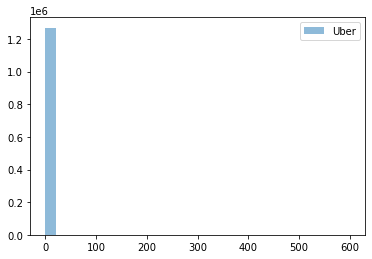

In [88]:
from matplotlib import pyplot as plt

uberTimes = finalData[finalData.merchant_name == 'Uber'].time_of_order
lyftTimes = finalData[finalData.merchant_name == 'Lyft'].time_of_order
uberTimes.dropna()
lyftTimes.dropna()

uberTimeInMinutes = uberTimes.apply(
    lambda x: 60*int(x[0:x.find(':')]) + int(x[x.find(':')+1:x.find(':')+3]))

lyftTimeInMinutes = lyftTimes.apply(
    lambda x: 60*int(x[0:x.find(':')]) + int(x[x.find(':')+1:x.find(':')+3]))

b = np.linspace(0,600,30)

plt.hist(uberTimeInMinutes, b, alpha=0.5,label = 'Uber')
plt.legend(loc = 'upper right')
plt.show()


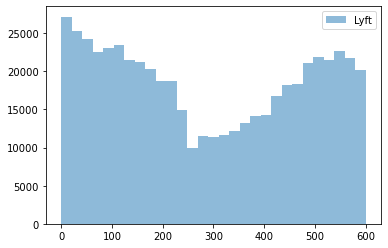

In [89]:
plt.hist(lyftTimeInMinutes ,b, alpha=0.5,label = 'Lyft')
plt.legend(loc = 'upper right')
plt.show()

As we can see from the above, Uber and Lyft have some serious differences in their data. Lyft appears to have a valid time component,  which shows high usage in the wee hours of the morning (near 0, which is midnight), and then it gradually sinks in the afternoon, only to pick up again in the evening (just in time for people's evening commute).

As for Uber, most of the data are clustered around 0, which could either mean that the orders are overwhelmingly being placed close to midnight or (perhaps more likely) the time data for Uber are deficient for some reason. This is something that we could further investigate. As a test, let's see what it looks like if we exclude 0.

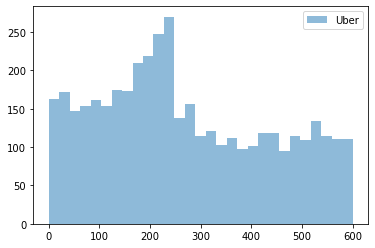

In [90]:
uberTimeInMinutes = uberTimeInMinutes[uberTimeInMinutes > 0]
plt.hist(uberTimeInMinutes, b, alpha=0.5,label = 'Uber')
plt.legend(loc = 'upper right')
plt.show()

As we can see, there are some nonzero elements here. This indicates that perhaps the time field is not entirely corrupt, but only that our logic for parsing it for Uber rows is insufficient. This would merit more investigation. We could use similar tools to investigate the distribution of dates as well, but we leave that as a future consideration and move on to speed and traffic patterns.

## Traffic Patterns and Speed

Since we have access to the total trip time and total travel time fields, we can determine the average and median speeds for each of Uber and Lyft. The below code handles this.

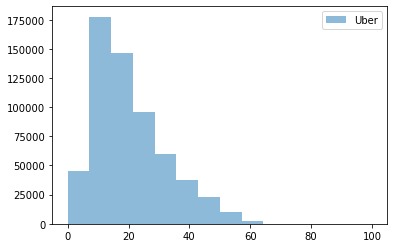

In [120]:
uberSpeed = finalData[(finalData.merchant_name == 'Uber') & (finalData.Distance_Traveled.notnull()) & (
    finalData.Distance_Traveled.apply(lambda x: x != "NaN")) & (finalData.Trip_Time.notnull()) & (
    finalData.Trip_Time.apply(lambda x: x != "NaN"))]
uberSpeed = uberSpeed[['Distance_Traveled','Trip_Time']]
uberSpeed["Hours"] = uberSpeed.Trip_Time.apply(
    lambda x: int(x[0:2]) if x.find(":") > 0 else 0)
uberSpeed['Minutes'] = uberSpeed.Trip_Time.apply(
    lambda x: int(x[3:5])/60.00 if x.count(':') == 2 else 0)
uberSpeed = uberSpeed[uberSpeed.Hours + uberSpeed.Minutes > 0]
uberSpeed['Average_Speed'] = uberSpeed.Distance_Traveled.astype(float) / (uberSpeed.Hours.astype(float) + uberSpeed.Minutes.astype(float))
uberSpeed

b1 = np.linspace(0,100,15)

plt.hist(uberSpeed.Average_Speed,b1,alpha=0.5,label='Uber')
plt.legend(loc = 'upper right')
plt.show()

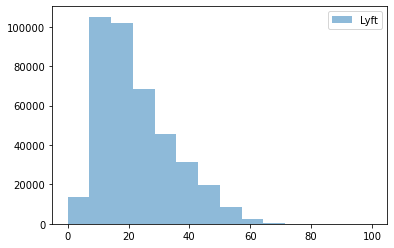

In [156]:
lyftSpeed = finalData[(finalData.merchant_name == 'Lyft') & (finalData.Distance_Traveled.notnull()) & (
    finalData.Distance_Traveled.apply(lambda x: x != "NaN")) & (finalData.Trip_Time.notnull()) & (
    finalData.Trip_Time.apply(lambda x: x != "NaN"))]
lyftSpeed = lyftSpeed[['Distance_Traveled','Trip_Time']]

lyftSpeed["Hours"] = lyftSpeed.Trip_Time.apply(
    lambda x: int(x[0:2]) if x.find(":") > 0 else 0)

lyftSpeed['Minutes'] = lyftSpeed.Trip_Time.apply(
    lambda x: x[3:5])

lyftSpeed = lyftSpeed[lyftSpeed.Minutes.str.contains(":") == False]

lyftSpeed = lyftSpeed[lyftSpeed.Hours.astype(int) + lyftSpeed.Minutes.astype(int).apply(
lambda x: x/60.00) > 0]

lyftSpeed['Average_Speed'] = lyftSpeed.Distance_Traveled.astype(float) / (lyftSpeed.Hours.astype(float) + lyftSpeed.Minutes.astype(float).apply(
lambda x: x/60.00))


plt.hist(lyftSpeed.Average_Speed,b1,alpha=0.5,label='Lyft')
plt.legend(loc = 'upper right')
plt.show()

As we can see from the above, the average speed for both firms appears similar.

# FINAL THOUGHTS: EXTENSIONS AND QUESTIONS

## Questions for the Vendor

Now that we have reached the end of the case study, I want to take this space to collect some of the questions that I would ask of the data provider, if given the opportunity. These come from the previous cells of analysis:

1. Are User_Ids universally assigned?
2. Why would a row ever be misssing an order_number?
3. Why would there be 2 rows with the same order_numbere and the same user_id?
4. Is it possible for there to be 2 or more user_ids connected to the same order number?
5. Typically, it appears as though order_numbers for Uber are 36 character-long strings and those for Lyft are 19 character-long strings. Why do we get some few that do not conform to these standards?
6. Why is it the case that my order_total integrity checks failed? What is the relationship between order total, subtotal, tax, and discount?

## Relational Database Modeling

Another point to make in ending the case study is that there are at least three different, normalized tables that one would create for this dataset. The following are the names of the tables and the fields from the file that I would associate with each:

- **Merchant**: This would have one row per merchant in the dataset. In this case, we have two: Uber and Lyft. The fields that I would associate with this table include: merchant_name.

- **User**: This would have one row per customer in the dataset. The fields would include: user_id.

- **Product**: This would have one row per product.

- **Order**: This would be our primary fact table. This table would have foreign keys to the Merchant, User, and Product tables. The fields that I would also include in this table from the dataset include: order_number, time_of_order, date_of_order, order_total_amount, order_tax, order_subtotal, order_total_qty, trip_time, distance_traveled, item_quantity, item_price, order_discount

Altogether, this would constitute a star schema. We could add additional fields to these tables as well, pending answers to some of our questions from the vendor.